# Mini Lab: Logistic Regression and SVMs
Billy Nayden
Sean Mcwhirter
Andrew Mejia
Rajesh Satluri

# 1) Create Models

First we will import the relevant packages for this analysis.  After the packages are imported, we build a helper funciton, import our data, and ensure the data looks satisfactory before diving into model construction.

In [1]:
import plotly
plotly.offline.init_notebook_mode()
import pandas as pd
import numpy as np 
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from pandas.plotting import boxplot
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
print(__doc__)



Using TensorFlow backend.


Automatically created module for IPython interactive environment


Below is the code that builds a helper function for learning curves. This helps us measure training time, accuracy, cross-validation score and other metrics quickly via graphs. The helper function nests multiple operations into a single function.

In [2]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve
#https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_ridge_regression.html#sphx-glr-auto-examples-miscellaneous-plot-kernel-ridge-regression-py
#https://scikit-learn.org/stable/modules/model_evaluation.html



def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
   
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()

    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


Next, we import our data and confirm it was loaded correctly.

In [3]:
raw_data_url = 'https://raw.githubusercontent.com/andrewmejia600/MSDS7331/master/RAW_DATA/95_cleaned_Raw_Data.csv'

In [4]:
ml_data = pd.read_csv(raw_data_url)

In [5]:
ml_data.head(n=5)

age         workclass  fnlwght  education  education_num_yr  \
0   39         State-gov    77516  Bachelors                13   
1   50  Self-emp-not-inc    83311  Bachelors                13   
2   38           Private   215646    HS-grad                 9   
3   53           Private   234721       11th                 7   
4   28           Private   338409  Bachelors                13   

       marital_status         occupation   relationship   race     sex  ...  \
0       Never-married       Adm-clerical  Not-in-family  White    Male  ...   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male  ...   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male  ...   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male  ...   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female  ...   

   annual_income  origin_descent  origin_descent_us income_outcome  \
0          <=50K   United States                  1              0   
1          <=50K   United States                  1              0   
2          <=50K   United States                  1              0   
3          <=50K   United States                  1              0   
4          <=50K           Carib                  0              0   

  level_of_employ age_range  education_level  marital_stat age_range_ord  \
0              FT     adult            CGRAD     Unmarried             2   
1              PT     adult            CGRAD       Married             2   
2              FT     adult           HSGRAD     Unmarried             2   
3              FT     adult               HS       Married             2   
4              FT     adult            CGRAD       Married             2   

  education_level_ord  
0                   6  
1                   6  
2                   3  
3                   2  
4                   6  

[5 rows x 24 columns]

Looking at our data types below we see that we have 14 *object* attributes and 10 *int64* attributes.

In [6]:
ml_data.dtypes

age                     int64
workclass              object
fnlwght                 int64
education              object
education_num_yr        int64
marital_status         object
occupation             object
relationship           object
race                   object
sex                    object
cap_gain                int64
cap_loss                int64
hours_per_week          int64
native_country         object
annual_income          object
origin_descent         object
origin_descent_us       int64
income_outcome          int64
level_of_employ        object
age_range              object
education_level        object
marital_stat           object
age_range_ord           int64
education_level_ord     int64
dtype: object

Our only column with null values is *origin_descent* which is why we will use the *origin_descent_us* attribute instead and mark all null values as 0.

In [7]:
ml_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30072 entries, 0 to 30071
Data columns (total 24 columns):
age                    30072 non-null int64
workclass              30072 non-null object
fnlwght                30072 non-null int64
education              30072 non-null object
education_num_yr       30072 non-null int64
marital_status         30072 non-null object
occupation             30072 non-null object
relationship           30072 non-null object
race                   30072 non-null object
sex                    30072 non-null object
cap_gain               30072 non-null int64
cap_loss               30072 non-null int64
hours_per_week         30072 non-null int64
native_country         30072 non-null object
annual_income          30072 non-null object
origin_descent         29611 non-null object
origin_descent_us      30072 non-null int64
income_outcome         30072 non-null int64
level_of_employ        30072 non-null object
age_range              30072 non-null object

Below we create a copy of our initial data set.

In [8]:
ml_data_copy = ml_data.copy()

We confirm the shape of the copied data below.

In [9]:
ml_data_copy.shape

(30072, 24)

In the below cells we address the *object* attributes. First we put them in a vector called `features_of_interest`. Next, we use OneHotEncoding to separate the *object* levels into separate columns. Then we format these as sparse matrices.

In [10]:
features_of_interest = ['workclass', 'education', 'marital_status','occupation', 'relationship', 'sex','race','origin_descent_us', 'level_of_employ', 'education_level', 'age_range', 'marital_stat']

In [11]:
tmp_cont = []
for feat in features_of_interest: 
    tmp_df = pd.get_dummies(ml_data_copy[feat],prefix=str(feat),sparse=True,drop_first=True)
    tmp_cont.append(tmp_df)
    feat_df = pd.concat(tmp_cont,axis=1)

ml_df = pd.concat([ml_data_copy,feat_df], axis=1)

ml_df.dtypes.unique()

array([dtype('int64'), dtype('O'), Sparse[uint8, 0]], dtype=object)

In [12]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30072 entries, 0 to 30071
Data columns (total 85 columns):
age                                     -30072 non-null int64
workclass                               -30072 non-null object
fnlwght                                 -30072 non-null int64
education                               -30072 non-null object
education_num_yr                        -30072 non-null int64
marital_status                          -30072 non-null object
occupation                              -30072 non-null object
relationship                            -30072 non-null object
race                                    -30072 non-null object
sex                                     -30072 non-null object
cap_gain                                -30072 non-null int64
cap_loss                                -30072 non-null int64
hours_per_week                          -30072 non-null int64
native_country                          -30072 non-null object
annual_income  

Next, we remove the *object* type attributes from our data set.

In [13]:
ml_df = ml_df.select_dtypes(include=['int64','Sparse[uint8, 0]'])

We confirm that the attributes are removed below.

In [14]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30072 entries, 0 to 30071
Data columns (total 71 columns):
age                                     -30072 non-null int64
fnlwght                                 -30072 non-null int64
education_num_yr                        -30072 non-null int64
cap_gain                                -30072 non-null int64
cap_loss                                -30072 non-null int64
hours_per_week                          -30072 non-null int64
origin_descent_us                       -30072 non-null int64
income_outcome                          -30072 non-null int64
age_range_ord                           -30072 non-null int64
education_level_ord                     -30072 non-null int64
workclass_Local-gov                     -30072 non-null Sparse[uint8, 0]
workclass_Private                       -30072 non-null Sparse[uint8, 0]
workclass_Self-emp-inc                  -30072 non-null Sparse[uint8, 0]
workclass_Self-emp-not-inc              -30072 non-n

We separate our response variable `income_outcome` as `y` and the remainder of our attributes as `x`. 

In [15]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4

#https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html



ML_std_clf = StandardScaler()
#removed some redundant dummy variables
if 'income_outcome' in ml_df:
    y = ml_df['income_outcome'].values 
    del ml_df['income_outcome'] 
    X = ml_df.values 

Below we view our data set with `income_outcome` removed.

In [16]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30072 entries, 0 to 30071
Data columns (total 70 columns):
age                                     -30072 non-null int64
fnlwght                                 -30072 non-null int64
education_num_yr                        -30072 non-null int64
cap_gain                                -30072 non-null int64
cap_loss                                -30072 non-null int64
hours_per_week                          -30072 non-null int64
origin_descent_us                       -30072 non-null int64
age_range_ord                           -30072 non-null int64
education_level_ord                     -30072 non-null int64
workclass_Local-gov                     -30072 non-null Sparse[uint8, 0]
workclass_Private                       -30072 non-null Sparse[uint8, 0]
workclass_Self-emp-inc                  -30072 non-null Sparse[uint8, 0]
workclass_Self-emp-not-inc              -30072 non-null Sparse[uint8, 0]
workclass_State-gov                     -

We revisit the copy of our data set we made earlier of our initial data set so we can more easily navigate it without the sparce matrices. Here is where it becomes clear that our data is very imbalanced. Just over 24% of all people in this data set make greater than $50k per year.

In [17]:
pd.crosstab(index=ml_data_copy['income_outcome'],columns= ml_data_copy['income_outcome'])

income_outcome      0     1
income_outcome             
0               22584     0
1                   0  7488

The desparity becomes even more evident when displayed graphically.

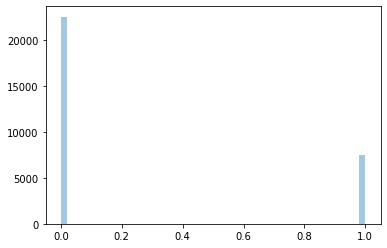

In [18]:
sns.distplot(y, kde=False)

To help handle the unbalance data set when constructing models, we can use Synthetic Minority Over-sampling (SMOTE) to over sample the class of respondents making more than $50k per year.

In [19]:
#https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html

upsample_smote_ = SMOTE(sampling_strategy='not majority')
X_upsam_smote_, y_upsam_smote_ = upsample_smote_.fit_sample(X, y)

#upsample_smote_ = SMOTEENN(sampling_strategy='not majority', random_state = 959)
#X_upsam_smote_, y_upsam_smote_ = upsample_smote_.fit_sample(X, y)


The SMOTE sampling process increases the size of our data set to 45,168 rows, which can be seen below.

In [20]:
smote_df_ = pd.DataFrame(X_upsam_smote_, columns = ml_df.columns)
smote_df_['income_outcome'] = y_upsam_smote_
smote_df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45168 entries, 0 to 45167
Data columns (total 71 columns):
age                                     45168 non-null float64
fnlwght                                 45168 non-null float64
education_num_yr                        45168 non-null float64
cap_gain                                45168 non-null float64
cap_loss                                45168 non-null float64
hours_per_week                          45168 non-null float64
origin_descent_us                       45168 non-null float64
age_range_ord                           45168 non-null float64
education_level_ord                     45168 non-null float64
workclass_Local-gov                     45168 non-null float64
workclass_Private                       45168 non-null float64
workclass_Self-emp-inc                  45168 non-null float64
workclass_Self-emp-not-inc              45168 non-null float64
workclass_State-gov                     45168 non-null float64
workclass

We can see in the cross tab and graph below, that now the data set is balanced between the two classes.

In [21]:
pd.crosstab(index=smote_df_['income_outcome'],columns= smote_df_['income_outcome'])

income_outcome      0      1
income_outcome              
0               22584      0
1                   0  22584

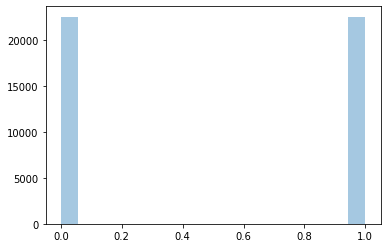

In [22]:
sns.distplot(y_upsam_smote_, kde=False)


Below we perform an 80/20 test train split on the data set, and create three separate iterations of this split for testing.  Even though we used SMOTE to obtain the same proportion of our target variable (income_outcome), we use stratified cross validation to ensure that we have the same proportions in our test/train splits.  Additionally, we use a random_state of 959 to ensure we are using the same samples with our logistic regression and support vector machines models. 

In [23]:
#https://scikit-learn.org/0.15/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
num_cv_iterations = 3
#num_instances = len(y)
#num_instances_smote_ = len(y_upsam_smote_)

cv_object = StratifiedShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state = 959)


                         
print(cv_object)


StratifiedShuffleSplit(n_splits=3, random_state=959, test_size=0.2,
            train_size=None)


## Logistic Regression Models


### LOGISTIC REGRESSION MODEL 1 -- LR Full
Below is our first logisitc regression model with OneHotEncoded binary and categorical data, using an 80/20 test/train split.  We also make a logistic regression pipeline using StandardScalar to scale our data as the continuous variables are on very different scales, e.g. age and cap_gains. We also evaluate the runtime as part of the performance evaluation.  We also include the AUC score in addition to our main metric of accuracy to ensure we are not ignoring signals of a flimsy accuracy score.

In [24]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
##https://docs.python.org/3/library/time.html#functions




#lr_clf = LogisticRegression(penalty='elasticnet', C=1.0, class_weight=None, solver='saga', l1_ratio = 0.5 )
lr_clf = LogisticRegression(penalty='l2', C=0.5, class_weight=None, solver='liblinear')
lr_clf_pipe = make_pipeline(StandardScaler(),lr_clf)


iter_num=0
weights_full = []
accuracies_full = []
auc_scores_full = []
runtimes_full = []

for train_indices, test_indices in cv_object.split(X,y): 

    t = time.process_time()
    
    lr_clf_pipe.fit(X[train_indices], y[train_indices])
    y_hat = lr_clf_pipe.predict(X[test_indices]) # get test set precitions
    
    elapsed_time = time.process_time() - t
    

    # now let's get the accuracy and confusion matrix for these iterations of training/testing
    acc = mt.accuracy_score(y[test_indices],y_hat)
    f1_scor_ = mt.f1_score(y[test_indices],y_hat)
    prec_scor_ = mt.precision_score(y[test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(y[test_indices],y_hat)
    conf = mt.confusion_matrix(y[test_indices],y_hat)
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    
    weights_full.append(lr_clf_pipe.named_steps['logisticregression'].coef_[0])
    accuracies_full.append(acc)
    auc_scores_full.append(auc_scor_)
    runtimes_full.append(elapsed_time)
    

  

    iter_num+=1

#Mean accuracy/f1/and train time for later comparison

mean_accuracy_full = (sum(accuracies_full)/len(accuracies_full))*100
mean_auc_score_full = (sum(auc_scores_full)/len(auc_scores_full))*100
mean_runtimes_full = (sum(runtimes_full)/len(runtimes_full))

print("The mean accuracy of the full logistic regression model is ", mean_accuracy_full, "%")
print("The mean AUC score of the full logistic regression model is ", mean_auc_score_full, "%")
print("The mean Train Time of the full logistic regression model is ", mean_runtimes_full, "seconds")


====Iteration 0  ====

Accuracy:  0.8443890274314214 

f1_score: 0.6640344580043072 

precision_score: 0.718167701863354 

roc_auc_score: 0.7685634569064561 

Confusion Matrix: 

      0    1
0  4154  363
1   573  925 

Train Time:  1.734375 s

====Iteration 1  ====

Accuracy:  0.8467165419783874 

f1_score: 0.6639941690962099 

precision_score: 0.7311396468699839 

roc_auc_score: 0.7669899619683302 

Confusion Matrix: 

      0    1
0  4182  335
1   587  911 

Train Time:  1.46875 s

====Iteration 2  ====

Accuracy:  0.8470490440565254 

f1_score: 0.6582466567607728 

precision_score: 0.7420435510887772 

roc_auc_score: 0.761634212009637 

Confusion Matrix: 

      0    1
0  4209  308
1   612  886 

Train Time:  1.640625 s

The mean accuracy of the full logistic regression model is  84.60515378221115 %
The mean AUC score of the full logistic regression model is  76.57292102948078 %
The mean Train Time of the full logistic regression model is  1.6145833333333333 seconds


As we can see from the results above, we get a mean accuracy of 84.61%, but the mean F1 score is only 6.21%.  We feel that we can improve upon our F1 score. Our ROC Curve shows the three iterations bowing off the 45 degree horizontal, visually indicating that our model is effective.

In [25]:
#weights_full

In [26]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4

error_y=dict(
            type='data',
            array=np.std(weights_full,axis=0),
            visible=True
        )

graph1 = {'x': ml_df.columns,
          'y': np.mean(weights_full,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars (Full Model)', 'height': 1000, 'width': 1400, 'font': {'size':14}}
plotly.offline.iplot(fig)


### LOGISTIC REGRESSION MODEL 2 -- LR Reduced

Let's select the important variables from chart above and look at age, education_num_yr, cap_gain, relationship_Not-in-family, relationship_Other-relative, relationship_Own-child, relationship_Unmarried, relationship_Wife, sex_Male, age_range_child, age_range_senior. We can expect the Train Time to decrease significantly given that we are using fewer attributes, but we will see how drastically our accuracy and AUC scores change.

In [27]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4
Xnew = ml_df[['age', 'education_num_yr', 'cap_gain', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'sex_Male', 'age_range_child', 'age_range_senior']].values

weights_reduced = []
accuracies_reduced = []
auc_scores_reduced = []
runtimes_reduced = []

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    lr_clf_pipe.fit(Xnew[train_indices],y[train_indices])
    
    weights_reduced.append(lr_clf_pipe.named_steps['logisticregression'].coef_[0])
    iter_num =+1
    
weights_reduced = np.array(weights_reduced)

error_y=dict(
            type='data',
            array=np.std(weights_reduced,axis=0),
            visible=True
        )

graph1 = {'x': ['age', 'education_num_yr', 'cap_gain', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'sex_Male', 'age_range_child', 'age_range_senior'],
          'y': np.mean(weights_reduced,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars (Reduced Model)', 'height': 1000, 'width': 1400, 'font': {'size':14}}

plotly.offline.iplot(fig)

In [28]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    
    
    t = time.process_time()
    lr_clf_pipe.fit(Xnew[train_indices],y[train_indices])
    
    y_hat = lr_clf_pipe.predict(Xnew[test_indices])
    
    elapsed_time = time.process_time() - t
    


    acc = mt.accuracy_score(y[test_indices],y_hat)
    conf = mt.confusion_matrix(y[test_indices],y_hat)
    f1_scor_ = mt.f1_score(y[test_indices],y_hat)
    prec_scor_ = mt.precision_score(y[test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(y[test_indices],y_hat)
    conf = mt.confusion_matrix(y[test_indices],y_hat)
    
    accuracies_reduced.append(acc)
    auc_scores_reduced.append(auc_scor_)
    runtimes_reduced. append(elapsed_time)
    

    print("====Iteration",iter_num," ====\n")
    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    iter_num+=1

    
#Mean accuracy/f1/and train time for later comparison

mean_accuracy_reduced = (sum(accuracies_reduced)/len(accuracies_reduced))*100
mean_auc_score_reduced = (sum(auc_scores_reduced)/len(auc_scores_reduced))*100
mean_runtime_reduced = (sum(runtimes_reduced)/len(runtimes_reduced))
    
print("The mean accuracy of the reduced logistic regression model is ", mean_accuracy_reduced, "%")
print("The mean AUC score of the reduced logistic regression model is ", mean_auc_score_reduced, "%")
print("The mean Train Time of the reduced logistic regression model is ", mean_runtime_reduced, "seconds")


====Iteration 0  ====

Accuracy:  0.8335827098919368 

f1_score: 0.6241081487044687 

precision_score: 0.7133047210300429 

roc_auc_score: 0.740398385213197 

Confusion Matrix: 

      0    1
0  4183  334
1   667  831 

Train Time:  0.265625 s

====Iteration 1  ====

Accuracy:  0.8314214463840399 

f1_score: 0.6190833959429001 

precision_score: 0.7079037800687286 

roc_auc_score: 0.7373977789883227 

Confusion Matrix: 

      0    1
0  4177  340
1   674  824 

Train Time:  0.21875 s

====Iteration 2  ====

Accuracy:  0.8370739817123857 

f1_score: 0.6216216216216217 

precision_score: 0.7371794871794872 

roc_auc_score: 0.7369227156391535 

Confusion Matrix: 

      0    1
0  4230  287
1   693  805 

Train Time:  0.21875 s

The mean accuracy of the reduced logistic regression model is  83.40260459961209 %
The mean AUC score of the reduced logistic regression model is  73.82396266135576 %
The mean Train Time of the reduced logistic regression model is  0.234375 seconds


Observing the results above, we can see that narrowing down the attributes to those with the highest weights, we didn't take a significant hit on the mean accuracy or AUC scores.  We will dive further into the differneces in the Model Advantages section, but it seems we have saved significant time and only sacrificed minimal accuracy and AUC. 

### LOGISTIC REGRESSION MODEL 3 -- LR SMOTE


Here we use Logistic Regression and upsample the minority population of those making over $50,000 using SMOTE.  When upsampling our minority variable of over 50,000, we need to keep in mind that there is a potential danger of overfitting.

In [29]:
lr_clf = LogisticRegression(penalty='l2', C=0.1, class_weight=None, solver='sag', max_iter=1e6 )
#lr_clf = LogisticRegression(penalty='l2', C=0.5, class_weight=None, solver='liblinear')
lr_clf_pipe = make_pipeline(StandardScaler(),lr_clf)


iter_num=0
weights_smote = []
accuracies_smote = []
auc_scores_smote = []
runtimes_smote = []


for train_indices, test_indices in cv_object.split(X_upsam_smote_,y_upsam_smote_): 

    t = time.process_time()
    
    lr_clf_pipe.fit(X_upsam_smote_[train_indices], y_upsam_smote_ [train_indices])
    y_hat = lr_clf_pipe.predict(X_upsam_smote_[test_indices]) # get test set precitions
    
    elapsed_time = time.process_time() - t
    

    # now let's get the accuracy and confusion matrix for these iterations of training/testing
    acc = mt.accuracy_score(y_upsam_smote_ [test_indices],y_hat)
    f1_scor_ = mt.f1_score(y_upsam_smote_ [test_indices],y_hat)
    prec_scor_ = mt.precision_score(y_upsam_smote_ [test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(y_upsam_smote_ [test_indices],y_hat)
    conf = mt.confusion_matrix(y_upsam_smote_ [test_indices],y_hat)
    
    accuracies_smote.append(acc)
    auc_scores_smote.append(auc_scor_)
    runtimes_smote.append(elapsed_time)
    
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    
    weights_smote.append(lr_clf_pipe.named_steps['logisticregression'].coef_[0])
    iter_num+=1

weights_smote = np.array(weights_smote)

#Mean accuracy/f1/and train time for later comparison

mean_accuracy_smote = (sum(accuracies_smote)/len(accuracies_smote))*100
mean_auc_score_smote = (sum(auc_scores_smote)/len(auc_scores_smote))*100
mean_runtime_smote = (sum(runtimes_smote)/len(runtimes_smote))

print("The mean accuracy of the SMOTE logistic regression model is", mean_accuracy_smote, "%")
print("The mean AUC score of the SMOTE logistic regression model is", mean_auc_score_smote, "%")
print("The mean Train TIme for the SMOTE logistic regression model is ", mean_runtime_smote, "seconds")

====Iteration 0  ====

Accuracy:  0.8267655523577596 

f1_score: 0.832063526129413 

precision_score: 0.8073719283631821 

roc_auc_score: 0.8267655523577596 

Confusion Matrix: 

      0     1
0  3592   925
1   640  3877 

Train Time:  2.203125 s

====Iteration 1  ====

Accuracy:  0.8386096967013504 

f1_score: 0.842241938974248 

precision_score: 0.8237037037037037 

roc_auc_score: 0.8386096967013504 

Confusion Matrix: 

      0     1
0  3684   833
1   625  3892 

Train Time:  2.390625 s

====Iteration 2  ====

Accuracy:  0.8315253486827541 

f1_score: 0.8353526611856339 

precision_score: 0.8167971229109372 

roc_auc_score: 0.8315253486827541 

Confusion Matrix: 

      0     1
0  3651   866
1   656  3861 

Train Time:  2.0625 s

The mean accuracy of the SMOTE logistic regression model is 83.23001992472881 %
The mean AUC score of the SMOTE logistic regression model is 83.23001992472881 %
The mean Train TIme for the SMOTE logistic regression model is  2.21875 seconds


In [30]:
error_y=dict(
            type='data',
            array=np.std(weights_smote,axis=0),
            visible=True
        )

graph1 = {'x': ml_df.columns,
          'y': np.mean(weights_smote,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars (SMOTE Model)', 'height': 1000, 'width': 1400, 'font': {'size':14}}
plotly.offline.iplot(fig)

### LOGISTIC REGRESSION MODEL 4 -- LR SMOTE Reduced


Here we use a grid search to select the best parameters for our SMOTE model. After we are able to select the best parameters, we will rerun our upsampled logistic regression model with the highest-weighted attributes from our LR SMOTE model(age, cap_gain, sex_Male, hours_per_week, and educaiton _num_yr). 

In [31]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py
#https://scikit-learn.org/stable/modules/grid_search.html#gridsearch-scoring
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html



X_train_smote_, X_test_smote_, y_train_smote_, y_test_smote_ = train_test_split( X_upsam_smote_, y_upsam_smote_, test_size=0.2, random_state=959)




tuned_parameters = [{'C': [1e-1, 0.5, 1], 
                     'max_iter' : [1e6], 
                     'penalty' : ['l2'], 
                     'class_weight' : [None], 
                     'solver' : ['sag']
                    }]


clf = GridSearchCV(LogisticRegression(), tuned_parameters, scoring='f1', cv=3)

clf.fit(X_train_smote_,y_train_smote_)

    
print(clf.best_params_)

{'C': 0.1, 'class_weight': None, 'max_iter': 1000000.0, 'penalty': 'l2', 'solver': 'sag'}


In [32]:
#Xnew_smote_ = ml_df[['age','cap_gain','sex_Male', 'marital_stat_Unmarried', 'marital_status_Married-civ-spouse', 'education_Preschool','education_Prof-school']].values

Xnew_smote_ = ml_df[['age','cap_gain','sex_Male', 'hours_per_week', 'education_num_yr']].values

Xnew_upsam_smote_, ynew_upsam_smote_ = upsample_smote_.fit_sample(Xnew_smote_, y)

weights_smote_reduced = []
accuracies_smote_reduced = []
auc_scores_smote_reduced = []
runtimes_smote_reduced = []


for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew_upsam_smote_, ynew_upsam_smote_)):
    lr_clf_pipe.fit(Xnew_upsam_smote_[train_indices],ynew_upsam_smote_[train_indices])
    
    weights_smote_reduced.append(lr_clf_pipe.named_steps['logisticregression'].coef_[0])
    iter_num =+1
    
weights_smote_reduced = np.array(weights_smote_reduced)

error_y=dict(
            type='data',
            array=np.std(weights_smote_reduced,axis=0),
            visible=True
        )

graph1 = {#'x': ['age','cap_gain','sex_Male', 'marital_stat_Unmarried', 'marital_status_Married-civ-spouse', 'education_Preschool','education_Prof-school'],
          'x': ['age','cap_gain','sex_Male', 'hours_per_week', 'education_num_yr'],
          'y': np.mean(weights_smote_reduced,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars (Reduced SMOTE Model)', 'height': 1000, 'width': 1400, 'font': {'size':14}}

plotly.offline.iplot(fig)

    


In [33]:
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew_upsam_smote_, ynew_upsam_smote_)):
    
   
    
    t = time.process_time()
    lr_clf_pipe.fit(Xnew_upsam_smote_[train_indices],ynew_upsam_smote_[train_indices])
    
    y_hat = lr_clf_pipe.predict(Xnew_upsam_smote_[test_indices])
    
    elapsed_time = time.process_time() - t
    


    acc = mt.accuracy_score(ynew_upsam_smote_[test_indices],y_hat)
    conf = mt.confusion_matrix(ynew_upsam_smote_[test_indices],y_hat)
    f1_scor_ = mt.f1_score(ynew_upsam_smote_[test_indices],y_hat)
    prec_scor_ = mt.precision_score(ynew_upsam_smote_[test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(ynew_upsam_smote_[test_indices],y_hat)
    conf = mt.confusion_matrix(ynew_upsam_smote_[test_indices],y_hat)
    
    accuracies_smote_reduced.append(acc)
    auc_scores_smote_reduced.append(auc_scor_)
    runtimes_smote_reduced.append(elapsed_time)
    
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")

    iter_num+=1


#Mean accuracy/f1/and train time for later comparison

mean_accuracy_smote_reduced = (sum(accuracies_smote_reduced)/len(accuracies_smote_reduced))*100
mean_auc_score_smote_reduced = (sum(auc_scores_smote_reduced)/len(auc_scores_smote_reduced))*100
mean_runtime_smote_reduced = (sum(runtimes_smote_reduced)/len(runtimes_smote_reduced))

print("The mean accuracy of the reduced SMOTE logistic regression model is", mean_accuracy_smote_reduced, "%")
print("The mean AUC score of the reduced SMOTE logistic regression model is", mean_auc_score_smote_reduced, "%")
print("The mean Train TIme for the reduced SMOTE logistic regression model is ", mean_runtime_smote_reduced, "seconds")

====Iteration 0  ====

Accuracy:  0.7645561213194598 

f1_score: 0.7649464029174494 

precision_score: 0.7636804942630185 

roc_auc_score: 0.7645561213194598 

Confusion Matrix: 

      0     1
0  3446  1071
1  1056  3461 

Train Time:  0.09375 s

====Iteration 1  ====

Accuracy:  0.7643347354438786 

f1_score: 0.7615634449546422 

precision_score: 0.7706255666364461 

roc_auc_score: 0.7643347354438786 

Confusion Matrix: 

      0     1
0  3505  1012
1  1117  3400 

Train Time:  0.109375 s

====Iteration 2  ====

Accuracy:  0.7611246402479522 

f1_score: 0.7591517857142857 

precision_score: 0.7654737789781679 

roc_auc_score: 0.7611246402479521 

Confusion Matrix: 

      0     1
0  3475  1042
1  1116  3401 

Train Time:  0.09375 s

The mean accuracy of the reduced SMOTE logistic regression model is 76.33384990037636 %
The mean AUC score of the reduced SMOTE logistic regression model is 76.33384990037636 %
The mean Train TIme for the reduced SMOTE logistic regression model is  0.0989

Below we store the mean accuracy, AUC scores, and train times in a tabualar form to make it easier to compare model advantages later on.

In [34]:
#Creating a dataframe to store and review when discussing model advantages
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html

lr_scores = {'Model' : ['LR Full', 'LR Reduced', 'LR SMOTE', 'LR Rduced SMOTE'], 'Accuracy' : [mean_accuracy_full, mean_accuracy_reduced, mean_accuracy_smote, mean_accuracy_smote_reduced], 'AUC Score' : [mean_auc_score_full, mean_auc_score_reduced, mean_auc_score_smote, mean_auc_score_smote_reduced],'Train Time' : [mean_runtimes_full, mean_runtime_reduced, mean_runtime_smote, mean_runtime_smote_reduced]}

In [35]:
lr_summary = pd.DataFrame(data=lr_scores)
lr_summary

Model   Accuracy  AUC Score  Train Time
0          LR Full  84.605154  76.572921    1.614583
1       LR Reduced  83.402605  73.823963    0.234375
2         LR SMOTE  83.230020  83.230020    2.218750
3  LR Rduced SMOTE  76.333850  76.333850    0.098958

## SVM Models


### SVM Model 1 -- SVC-rbf 

Our first SVM model will use the rbf kernel and automatic gamma to reduce trian time.

In [36]:
svm_clf = SVC(C=0.5, kernel='rbf', gamma='auto') 


accuracy_SVC_rbf_GA=[]
auc_SVC_rbf_GA=[]
runtime_SVC_rbf_GA=[]

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X_upsam_smote_,y_upsam_smote_)): 
    

    ML_std_clf.fit(X_upsam_smote_[train_indices])
    X_train_scaled = ML_std_clf.transform(X_upsam_smote_[train_indices]) 
    X_test_scaled = ML_std_clf.transform(X_upsam_smote_[test_indices]) 
    
    t = time.process_time()

    svm_clf.fit(X_train_scaled, y_upsam_smote_[train_indices])  

    y_hat = svm_clf.predict(X_test_scaled)
    
    elapsed_time = time.process_time() - t

    acc = mt.accuracy_score(y_upsam_smote_[test_indices],y_hat)
    f1_scor_ = mt.f1_score(y_upsam_smote_[test_indices],y_hat)
    prec_scor_ = mt.precision_score(y_upsam_smote_[test_indices], y_hat)
    auc_scor_ = mt.roc_auc_score(y_upsam_smote_[test_indices],y_hat)
    conf = mt.confusion_matrix(y_upsam_smote_[test_indices],y_hat)
    
    accuracy_SVC_rbf_GA.append(acc)
    auc_SVC_rbf_GA.append(auc_scor_)
    runtime_SVC_rbf_GA.append(elapsed_time)
    
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    iter_num =+1
    
mean_accuracy_SVC_rbf_GA=sum(accuracy_SVC_rbf_GA)/len(accuracy_SVC_rbf_GA)*100
mean_auc_SVC_rbf_GA=sum(auc_SVC_rbf_GA)/len(auc_SVC_rbf_GA)*100
mean_runtime_SVC_rbf_GA=sum(runtime_SVC_rbf_GA)/len(runtime_SVC_rbf_GA)

print('The mean accuracy of SVC with the rbf kernel and automatic gamma is ',mean_accuracy_SVC_rbf_GA,'%')
print('The mean AUC Score of SVC with the rbf kernel and automatic gamma is ',mean_auc_SVC_rbf_GA,'%')
print('The mean Train Time of SVC with the rbf kernel and automatic gamma is ',mean_runtime_SVC_rbf_GA,'%')

====Iteration 0  ====

Accuracy:  0.8709320345361966 

f1_score: 0.8714159682399647 

precision_score: 0.8681608437705999 

roc_auc_score: 0.8709320345361966 

Confusion Matrix: 

      0     1
0  3917   600
1   566  3951 

Train Time:  86.328125 s

====Iteration 1  ====

Accuracy:  0.8763559884879345 

f1_score: 0.8760953965612867 

precision_score: 0.877945753668297 

roc_auc_score: 0.8763559884879345 

Confusion Matrix: 

      0     1
0  3968   549
1   568  3949 

Train Time:  87.0625 s

====Iteration 2  ====

Accuracy:  0.8800088554350233 

f1_score: 0.8799291094373062 

precision_score: 0.8805142983817336 

roc_auc_score: 0.8800088554350233 

Confusion Matrix: 

      0     1
0  3978   539
1   545  3972 

Train Time:  89.984375 s

The mean accuracy of SVC with the rbf kernel and automatic gamma is  87.57656261530515 %
The mean AUC Score of SVC with the rbf kernel and automatic gamma is  87.57656261530515 %
The mean Train Time of SVC with the rbf kernel and automatic gamma is  87.

### SVM Model 2 -- SGDClassifier

Here, we use stochastic gradient descent via SGDClassifier.  Using SGD, we can run multiple iterations quickly given the large size of our data set.  We also sue tuned parameters to optimize our model.


In [37]:
#SDG parameter best search
tuned_parameters = [{'alpha': [1e-3,1e-2, 1e-1], 
                     'fit_intercept' : [True],
                     'l1_ratio' : [0],
                     'learning_rate': ['optimal'], 
                     'n_iter_no_change': [5], 
                     'loss': ['hinge'], 
                     'penalty': ['l2'],
                     'max_iter' : [1e6],
                     'n_jobs': [-1]
                    }]


clf = GridSearchCV( SGDClassifier(), tuned_parameters, scoring='f1', cv=3)

clf.fit(X_train_smote_,y_train_smote_)

    
print(clf.best_params_)


{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000000.0, 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l2'}


In [38]:
regularize_const = 0.1
iterations = 10
#svm_sgd = SGDClassifier(alpha=regularize_const,
#        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
#        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

svm_sgd = SGDClassifier(alpha=0.001,
        fit_intercept=True, l1_ratio=0.00, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2', max_iter = 1e6)

accuracy_sdg = []
auc_sdg = []
runtime_sdg = []

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X_upsam_smote_,y_upsam_smote_)): 
    
    
    ML_std_clf.fit(X_upsam_smote_[train_indices])
    X_train_scaled = ML_std_clf.transform(X_upsam_smote_[train_indices]) 
    X_test_scaled = ML_std_clf.transform(X_upsam_smote_[test_indices]) 

    t = time.process_time()
    
    svm_sgd.fit(X_train_scaled,y_upsam_smote_[train_indices])
    yhat = svm_sgd.predict(X_test_scaled)
    
    elapsed_time = time.process_time() - t
    
    acc = mt.accuracy_score(y_upsam_smote_[test_indices],yhat)
    f1_scor_ = mt.f1_score(y_upsam_smote_[test_indices],yhat)
    prec_scor_ = mt.precision_score(y_upsam_smote_[test_indices], yhat)
    auc_scor_ = mt.roc_auc_score(y_upsam_smote_[test_indices],yhat)
    conf = mt.confusion_matrix(y_upsam_smote_[test_indices],yhat)
    
    accuracy_sdg.append(acc)
    auc_sdg.append(auc_scor_)
    runtime_sdg.append(elapsed_time)
    
    print("====Iteration",iter_num," ====\n")

    print("Accuracy: ", acc, "\n" )
    print("f1_score:", f1_scor_, "\n")
    print("precision_score:",prec_scor_ , "\n")
    print("roc_auc_score:",auc_scor_ , "\n")
    print("Confusion Matrix: \n")
    print (pd.DataFrame(conf),"\n")
    print("Train Time: ", elapsed_time,  "s\n")
    
    iter_num =+1

accuracy_sdg_mean = (sum(accuracy_sdg)/len(accuracy_sdg))*100
auc_sdg_mean = (sum(auc_sdg)/len(auc_sdg))*100
runtime_sdg_mean = (sum(runtime_sdg)/len(runtime_sdg))

print('The mean accuracy of SDG (SMOTE) is', accuracy_sdg_mean,'%')
print('The mean F1 Score of SDG (SMOTE) is', auc_sdg_mean,'%')

print('The mean Train Time of SDG (SMOTE) is', runtime_sdg_mean ,'seconds')

====Iteration 0  ====

Accuracy:  0.820234669028116 

f1_score: 0.8294834103317934 

precision_score: 0.7888955462352706 

roc_auc_score: 0.820234669028116 

Confusion Matrix: 

      0     1
0  3460  1057
1   567  3950 

Train Time:  0.3125 s

====Iteration 1  ====

Accuracy:  0.8375027673234448 

f1_score: 0.8440288992775181 

precision_score: 0.8114402451481103 

roc_auc_score: 0.8375027673234448 

Confusion Matrix: 

      0     1
0  3594   923
1   545  3972 

Train Time:  0.28125 s

====Iteration 2  ====

Accuracy:  0.8280938676112464 

f1_score: 0.8363368110443671 

precision_score: 0.7980691874497184 

roc_auc_score: 0.8280938676112464 

Confusion Matrix: 

      0     1
0  3513  1004
1   549  3968 

Train Time:  0.3125 s

The mean accuracy of SDG (SMOTE) is 82.8610434654269 %
The mean F1 Score of SDG (SMOTE) is 82.8610434654269 %
The mean Train Time of SDG (SMOTE) is 0.3020833333333333 seconds


### SVM Model 3 -- SVC-Linear

Here we use true SVM by subsampling our population to allow the linear SVC to run within a reasonable timeframe on our machines.  Since this model still takes a considerable amount of time to run, we only ran one instance in order to obtain the true support vectors for analysis in section three. 



In [39]:
accuracy_SVC_linear = []
auc_SVC_linear = []
runtime_SVC_linear = []

for (train_indices, test_indices) in cv_object.split(X_upsam_smote_,y_upsam_smote_): 
    
    X_train = X_upsam_smote_[train_indices]
    y_train = y_upsam_smote_[train_indices]
    
    X_test = X_upsam_smote_[test_indices]
    y_test = y_upsam_smote_[test_indices]
    
    ML_std_clf.fit(X_train)
    X_train_scaled_smote_ = ML_std_clf.transform(X_train) 
    X_test_scaled_smote_ = ML_std_clf.transform(X_test) 

In [40]:
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') 
t = time.process_time()
svm_clf.fit(X_train_scaled_smote_, y_train)  

y_hat = svm_clf.predict(X_test_scaled_smote_) 

elapsed_time = time.process_time() - t


acc = mt.accuracy_score(y_test,y_hat)
f1_scor_ = mt.f1_score(y_test,y_hat)
prec_scor_ = mt.precision_score(y_test, y_hat)
auc_scor_ = mt.roc_auc_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)

accuracy_SVC_linear.append(acc)
auc_SVC_linear.append(auc_scor_)
runtime_SVC_linear.append(elapsed_time)

print("Accuracy: ", acc, "\n" )
print("f1_score:", f1_scor_, "\n")
print("precision_score:",prec_scor_ , "\n")
print("roc_auc_score:",auc_scor_ , "\n")
print("Confusion Matrix: \n")
print (pd.DataFrame(conf),"\n")
print("Train Time: ", elapsed_time,  "s\n")

Accuracy:  0.8326322780606598 

f1_score: 0.8402366863905326 

precision_score: 0.8037194259146958 

roc_auc_score: 0.8326322780606596 

Confusion Matrix: 

      0     1
0  3546   971
1   541  3976 

Train Time:  192.21875 s



As we did with our logistic regression models, a table that summarizes the SVM model scores will allow us to compare models more effectively laer on.

In [41]:
#SVM Score summary table
SVM_scores = {'Model' : ['SVC-rbf', 'SGDClassifier', 'SVC-Linear'], 'Accuracy' : [mean_accuracy_SVC_rbf_GA, accuracy_sdg_mean, accuracy_SVC_linear], 'AUC Score' : [mean_auc_SVC_rbf_GA, auc_sdg_mean, auc_SVC_linear],'Train Time' : [mean_runtime_SVC_rbf_GA, runtime_sdg_mean, runtime_SVC_linear]}

SVM_summary = pd.DataFrame(data=SVM_scores)
SVM_summary


Model              Accuracy             AUC Score   Train Time
0        SVC-rbf               87.5766               87.5766      87.7917
1  SGDClassifier                82.861                82.861     0.302083
2     SVC-Linear  [0.8326322780606598]  [0.8326322780606596]  [192.21875]

Now that we have our support vectors, let's take a look and store them so we can analyze in section three.

In [42]:
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(14236, 70)
(14236,)
[7122 7114]


[[ 3.73331102e-01  4.69727027e-02  1.99091903e-01  1.96511265e+00
   1.83647404e-01  2.30023698e-01  2.02321037e-02 -8.26145702e-02
   1.32370906e-01 -1.19232748e-01 -1.47481045e-01 -2.02103340e-02
  -1.71764485e-01 -1.07852348e-01 -4.08736729e-02  5.78266476e-03
   1.62739816e-02 -3.88013697e-03 -7.82288288e-03 -4.33012793e-02
   3.46840890e-03 -1.01615492e-02  1.16855553e-02  2.58384777e-02
   1.38921289e-01 -4.21047890e-03 -2.28605301e-02 -1.65979380e-01
   1.65257825e-01  1.84214576e-02  3.31205263e-02  3.79917107e-01
  -6.88165180e-02 -6.60546386e-02 -1.16847548e-01  3.58686089e-02
  -1.28296612e-02 -8.50659628e-03  1.41293201e-01 -1.97147720e-01
  -1.46332027e-01 -7.18078612e-02 -2.75407572e-01 -1.42549397e-01
   8.65244461e-02  6.67185890e-02  4.08017978e-02  4.91212932e-02
  -6.32118960e-02 -2.91202354e-02 -5.04630007e-02 -1.02066876e-01
  -3.17421205e-02  2.28503801e-01  2.25683384e-01  1.13348675e-01
   1.34063823e-01  2.78664197e-02  2.17168147e-01  2.02321037e-02
  -1.04940

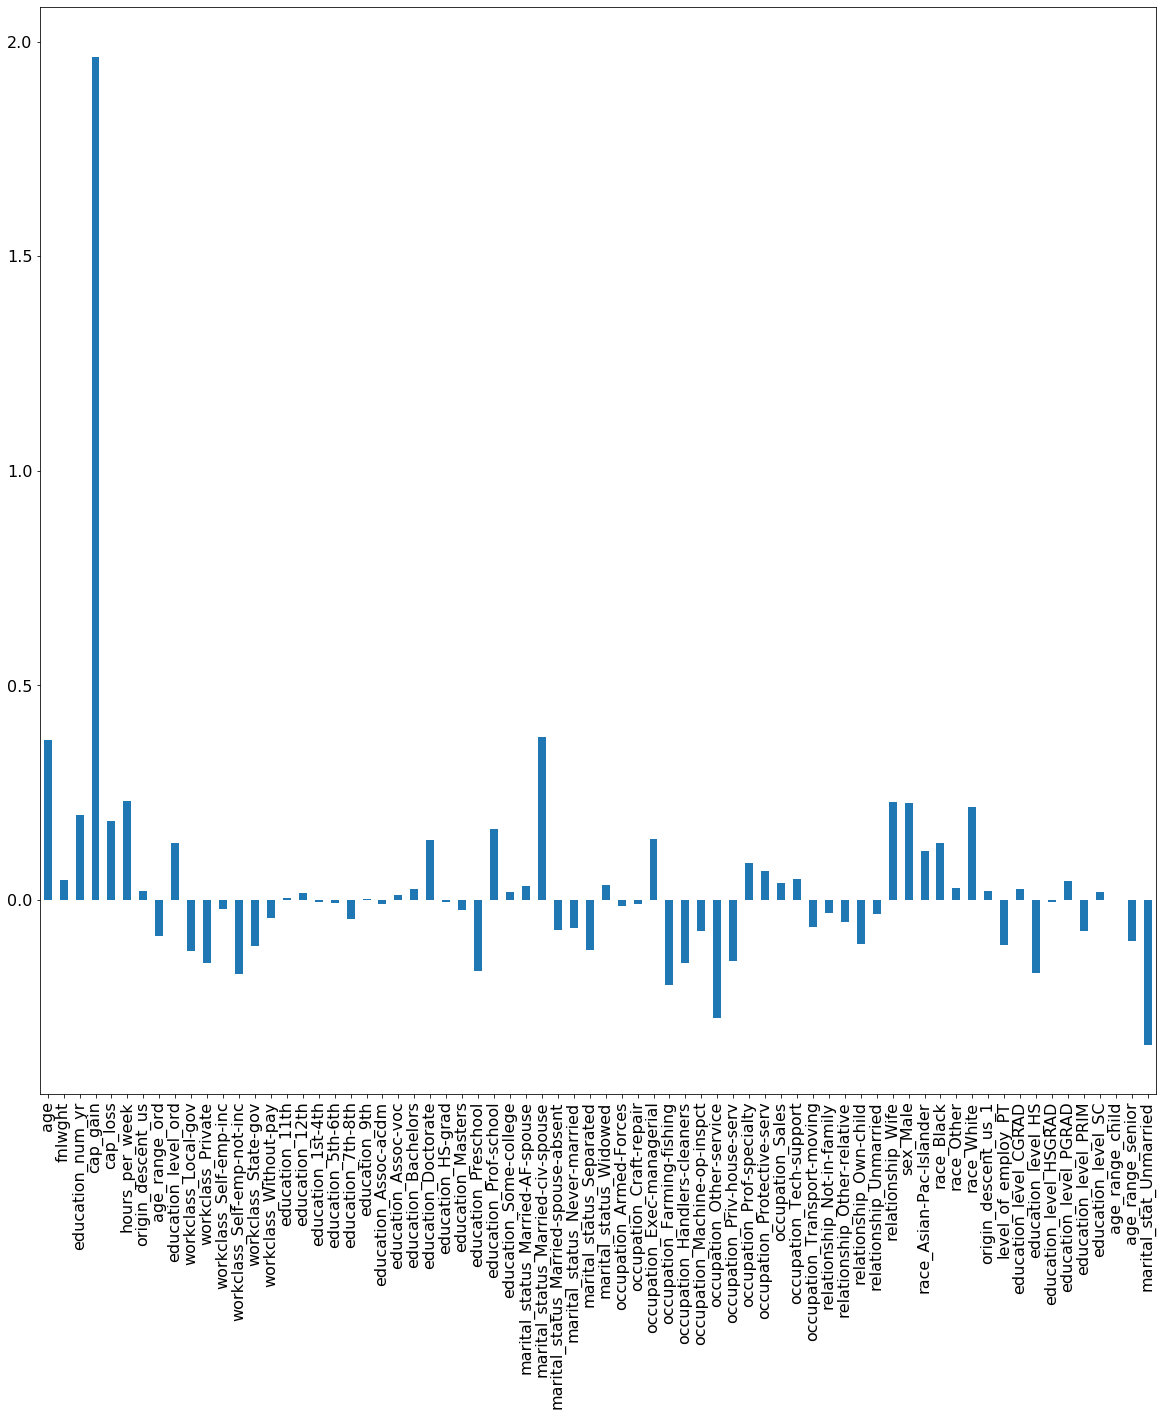

In [43]:
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=ml_df.columns)
weights.plot(kind='bar',figsize=(20,20), fontsize=16)

In [44]:
#https://github.com/jakemdrew/DataMiningNotebooks notebook 4

df_tested_on = smote_df_.iloc[train_indices].copy() 
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['income_outcome'] = y_upsam_smote_[svm_clf.support_] 

df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14236 entries, 656 to 29620
Data columns (total 71 columns):
age                                     14236 non-null float64
fnlwght                                 14236 non-null float64
education_num_yr                        14236 non-null float64
cap_gain                                14236 non-null float64
cap_loss                                14236 non-null float64
hours_per_week                          14236 non-null float64
origin_descent_us                       14236 non-null float64
age_range_ord                           14236 non-null float64
education_level_ord                     14236 non-null float64
workclass_Local-gov                     14236 non-null float64
workclass_Private                       14236 non-null float64
workclass_Self-emp-inc                  14236 non-null float64
workclass_Self-emp-not-inc              14236 non-null float64
workclass_State-gov                     14236 non-null float64
workcla

###### Support Vectors to analyze

<Figure size 720x288 with 0 Axes>

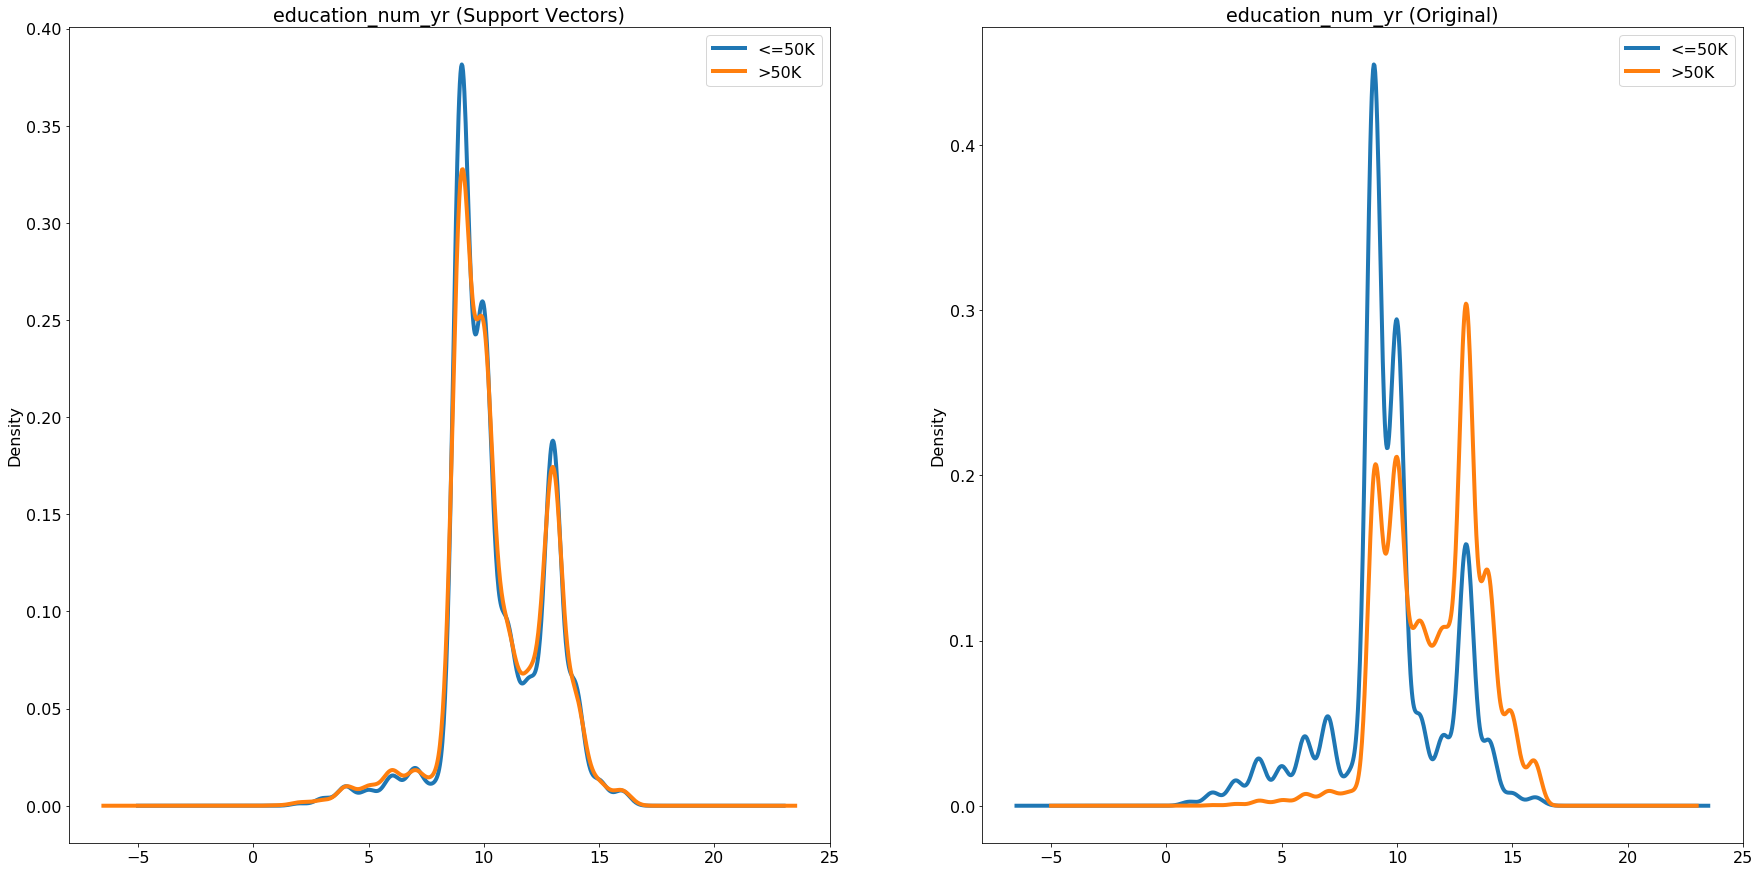

<Figure size 720x288 with 0 Axes>

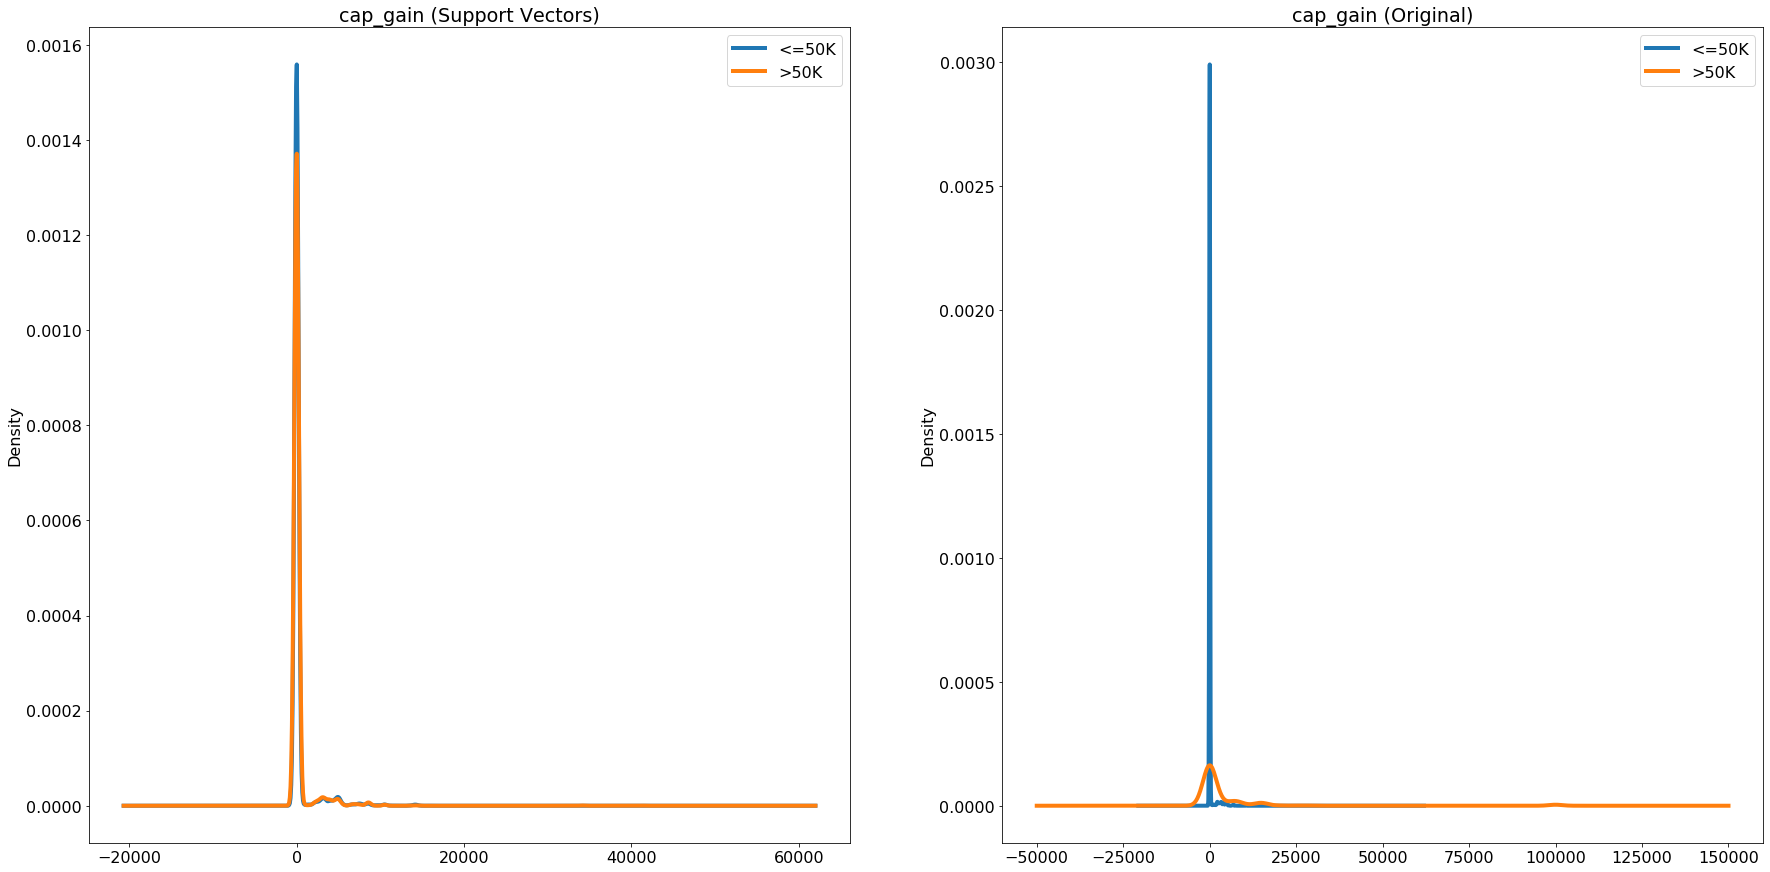

<Figure size 720x288 with 0 Axes>

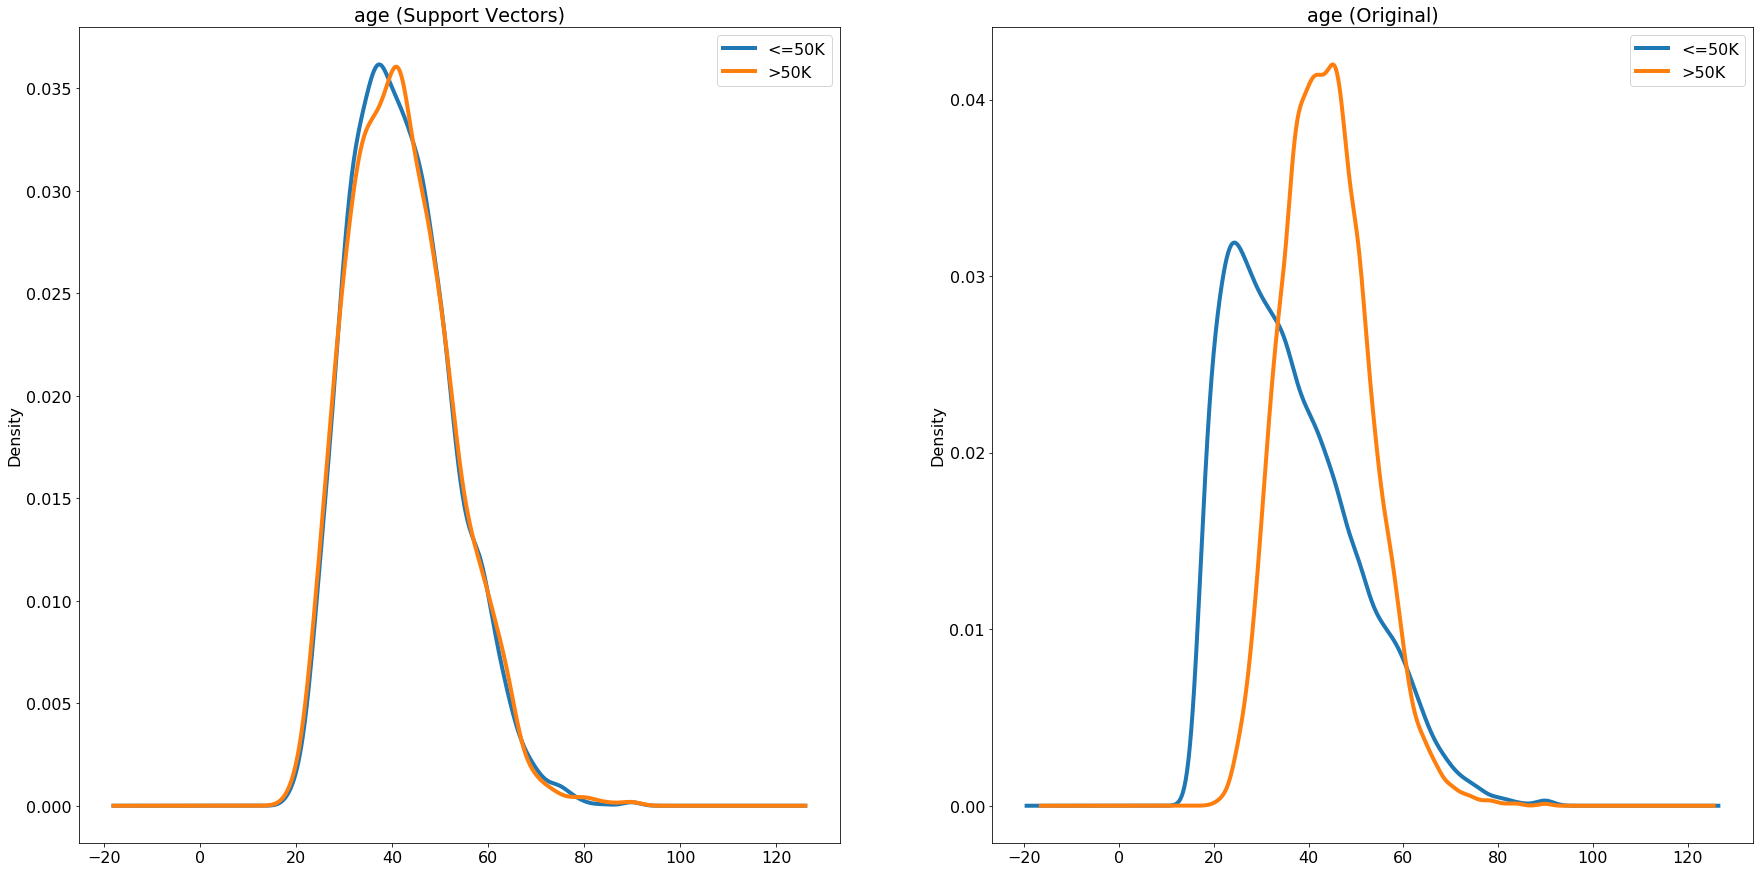

<Figure size 720x288 with 0 Axes>

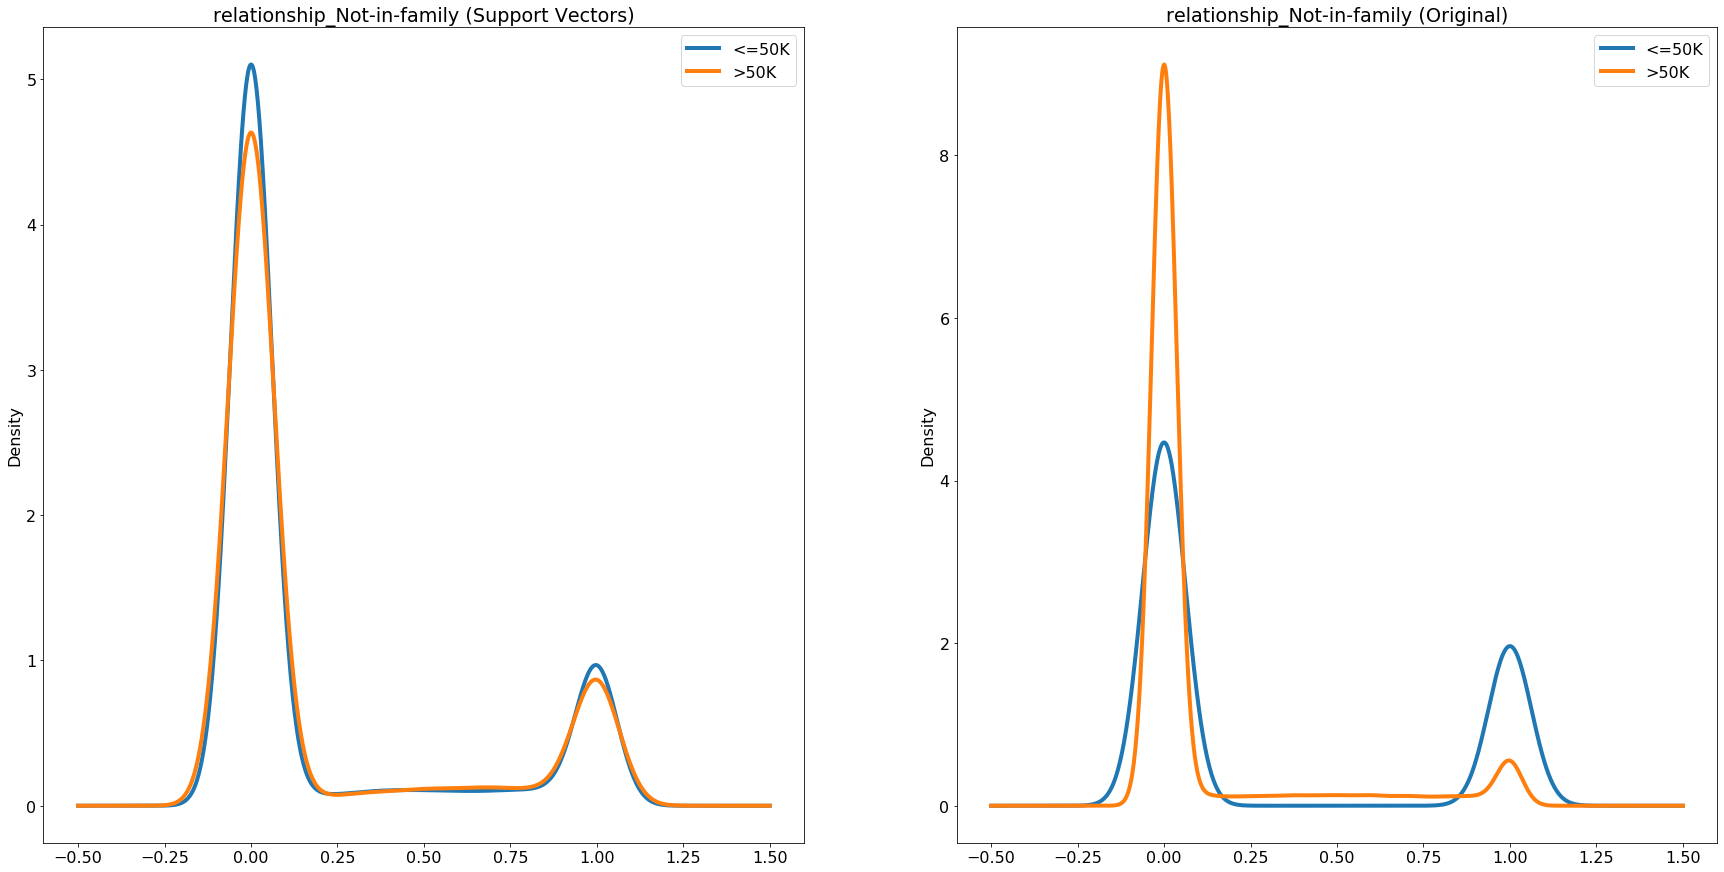

<Figure size 720x288 with 0 Axes>

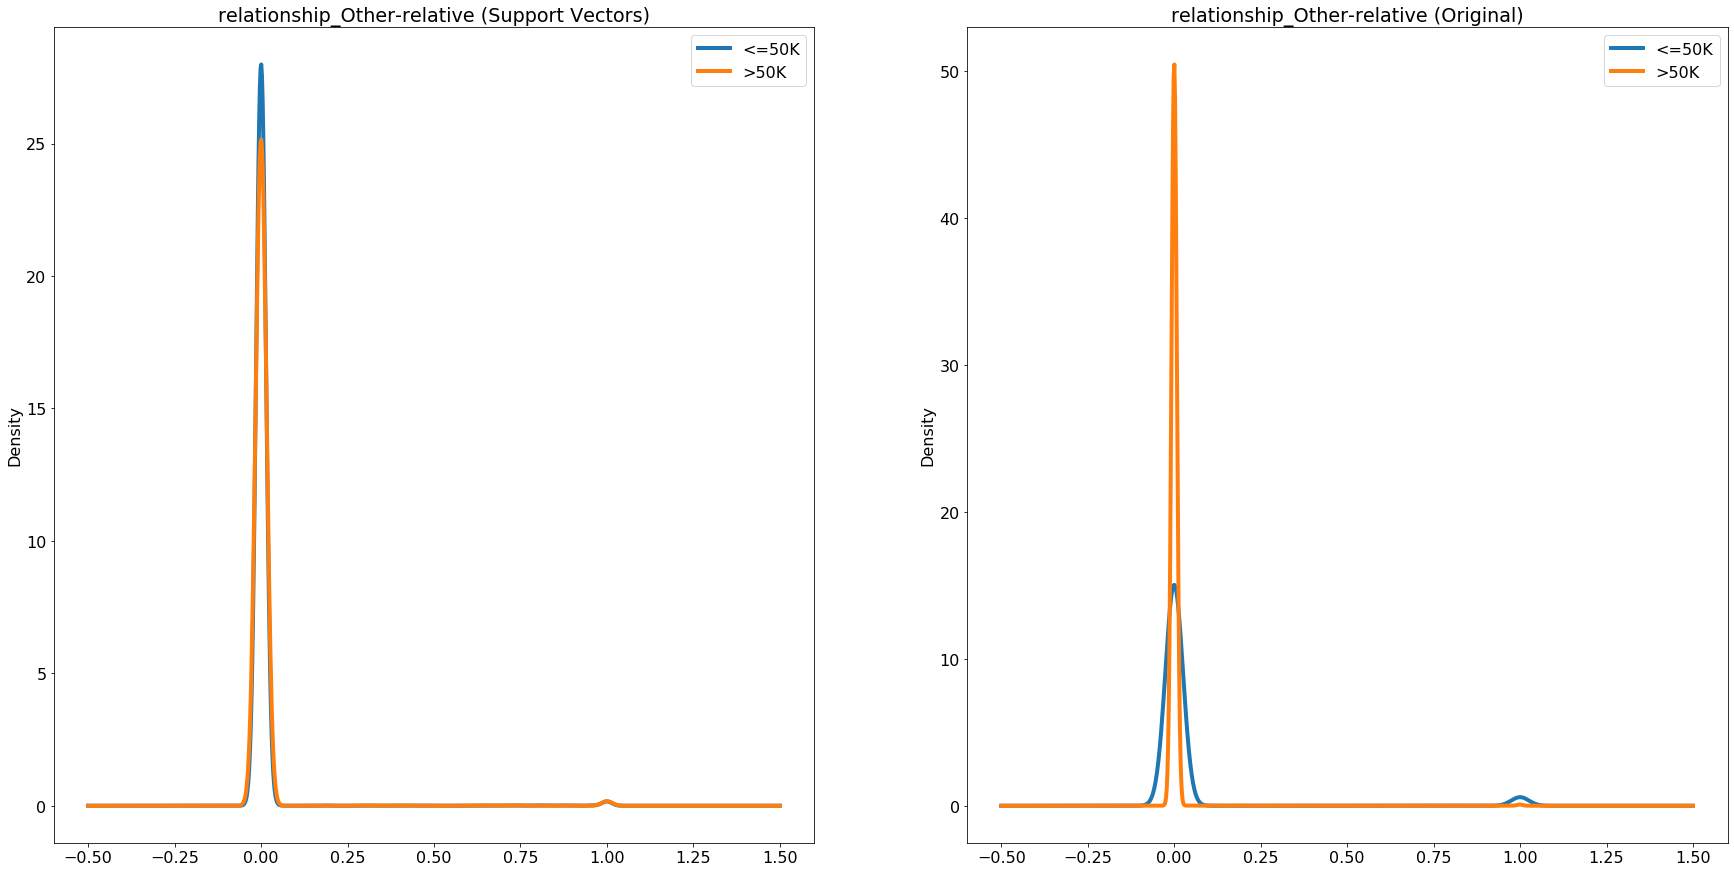

<Figure size 720x288 with 0 Axes>

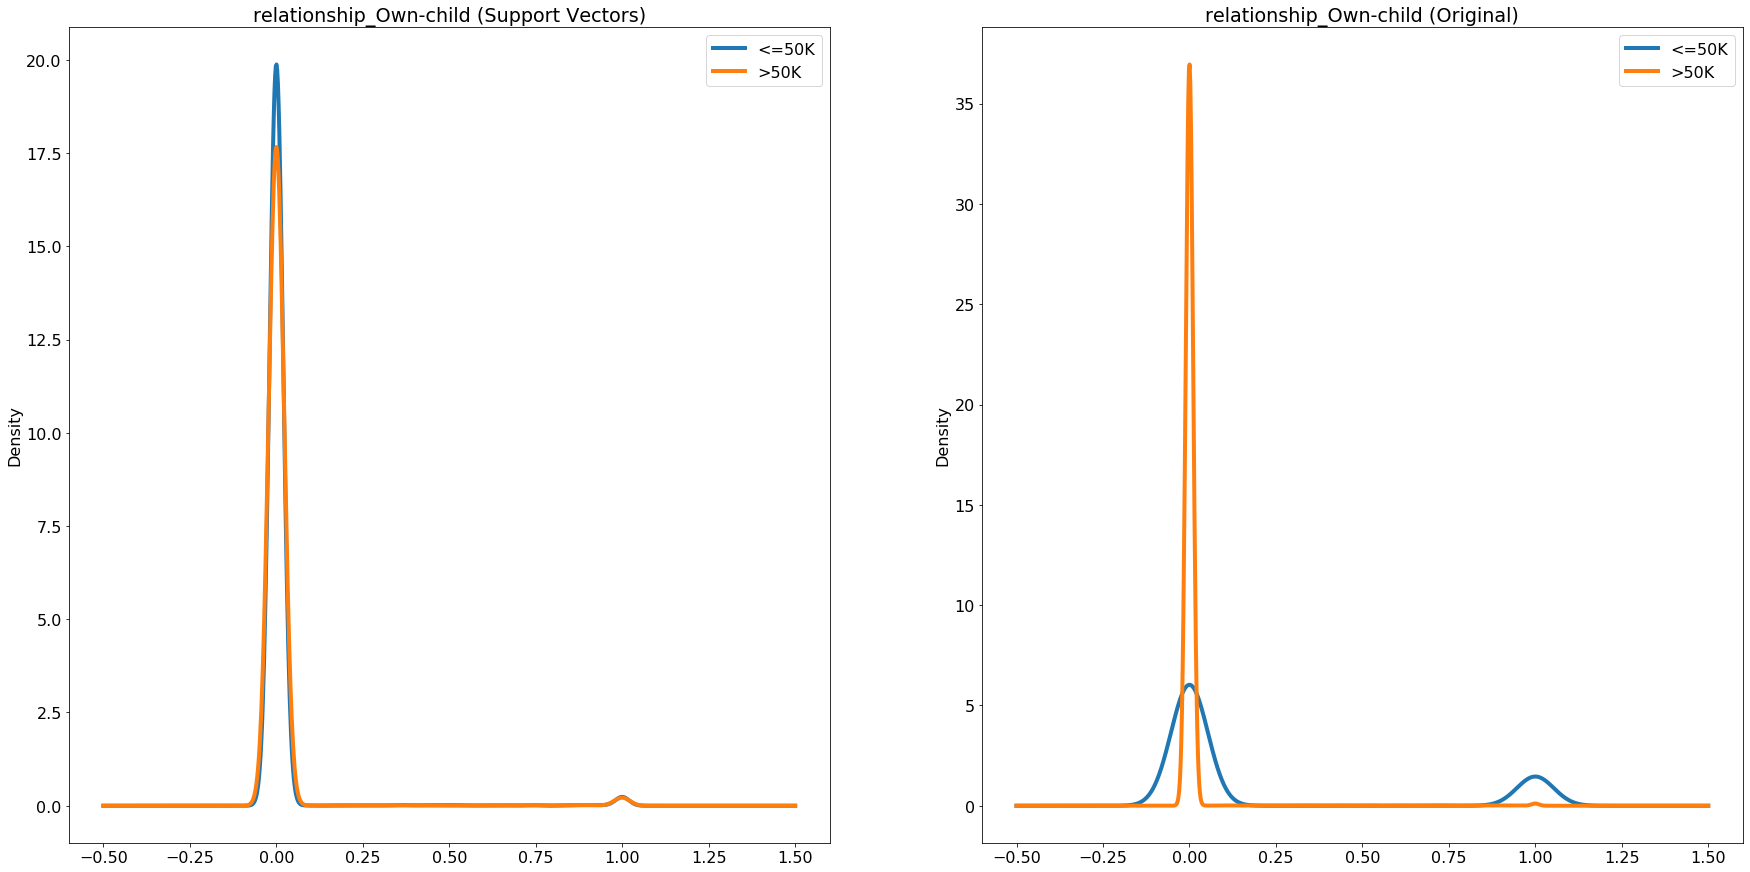

<Figure size 720x288 with 0 Axes>

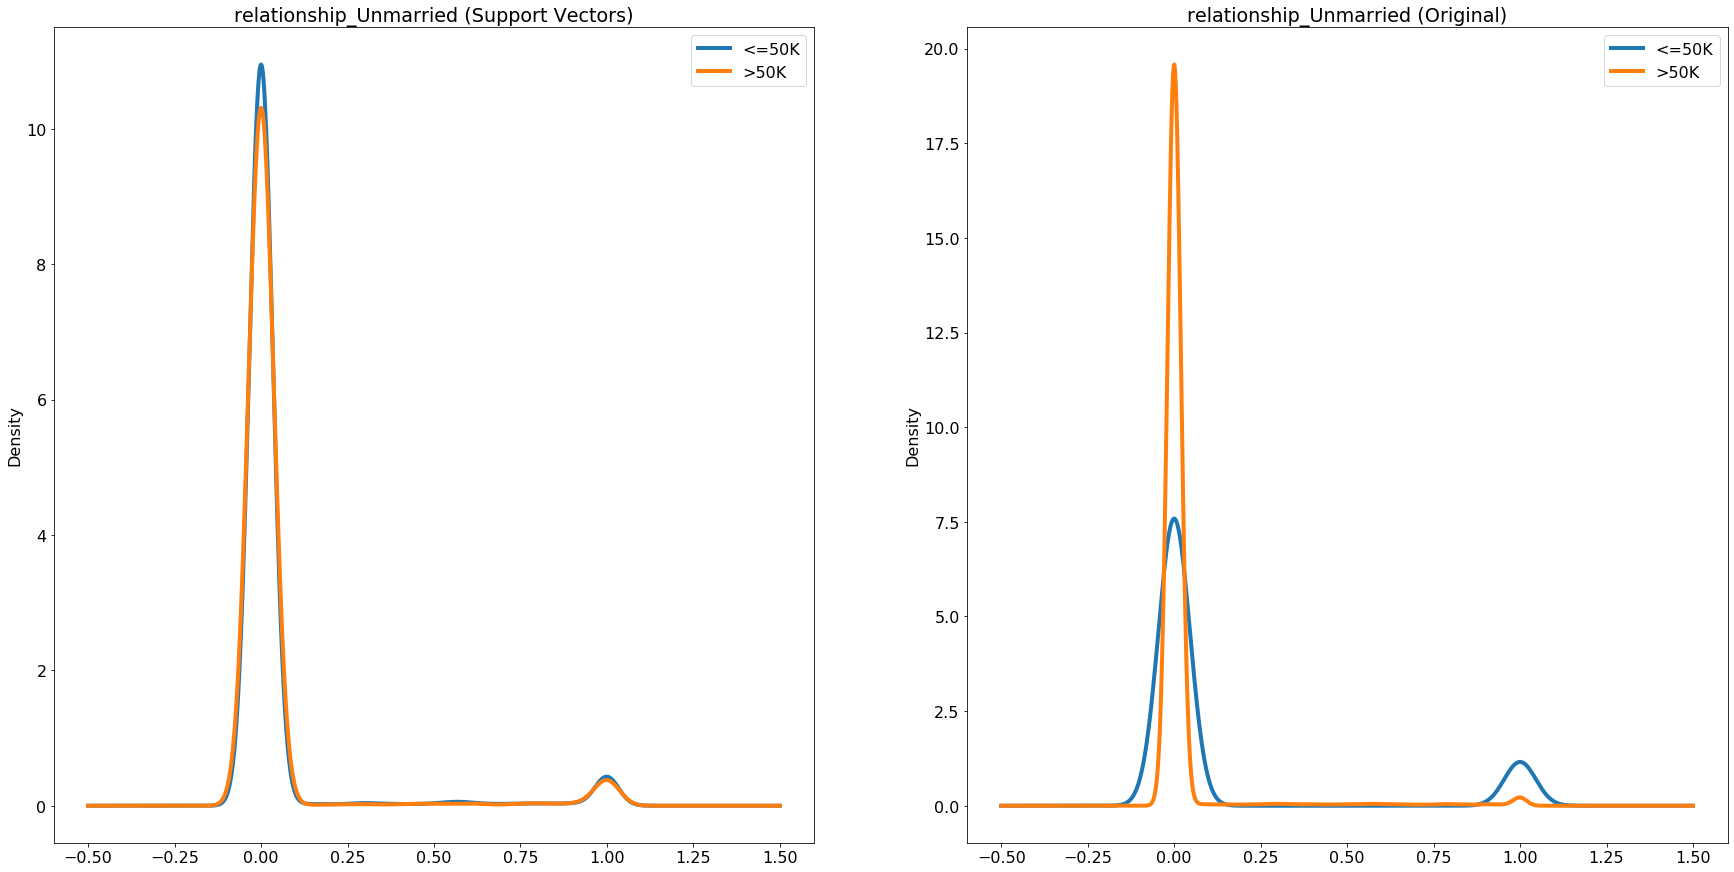

<Figure size 720x288 with 0 Axes>

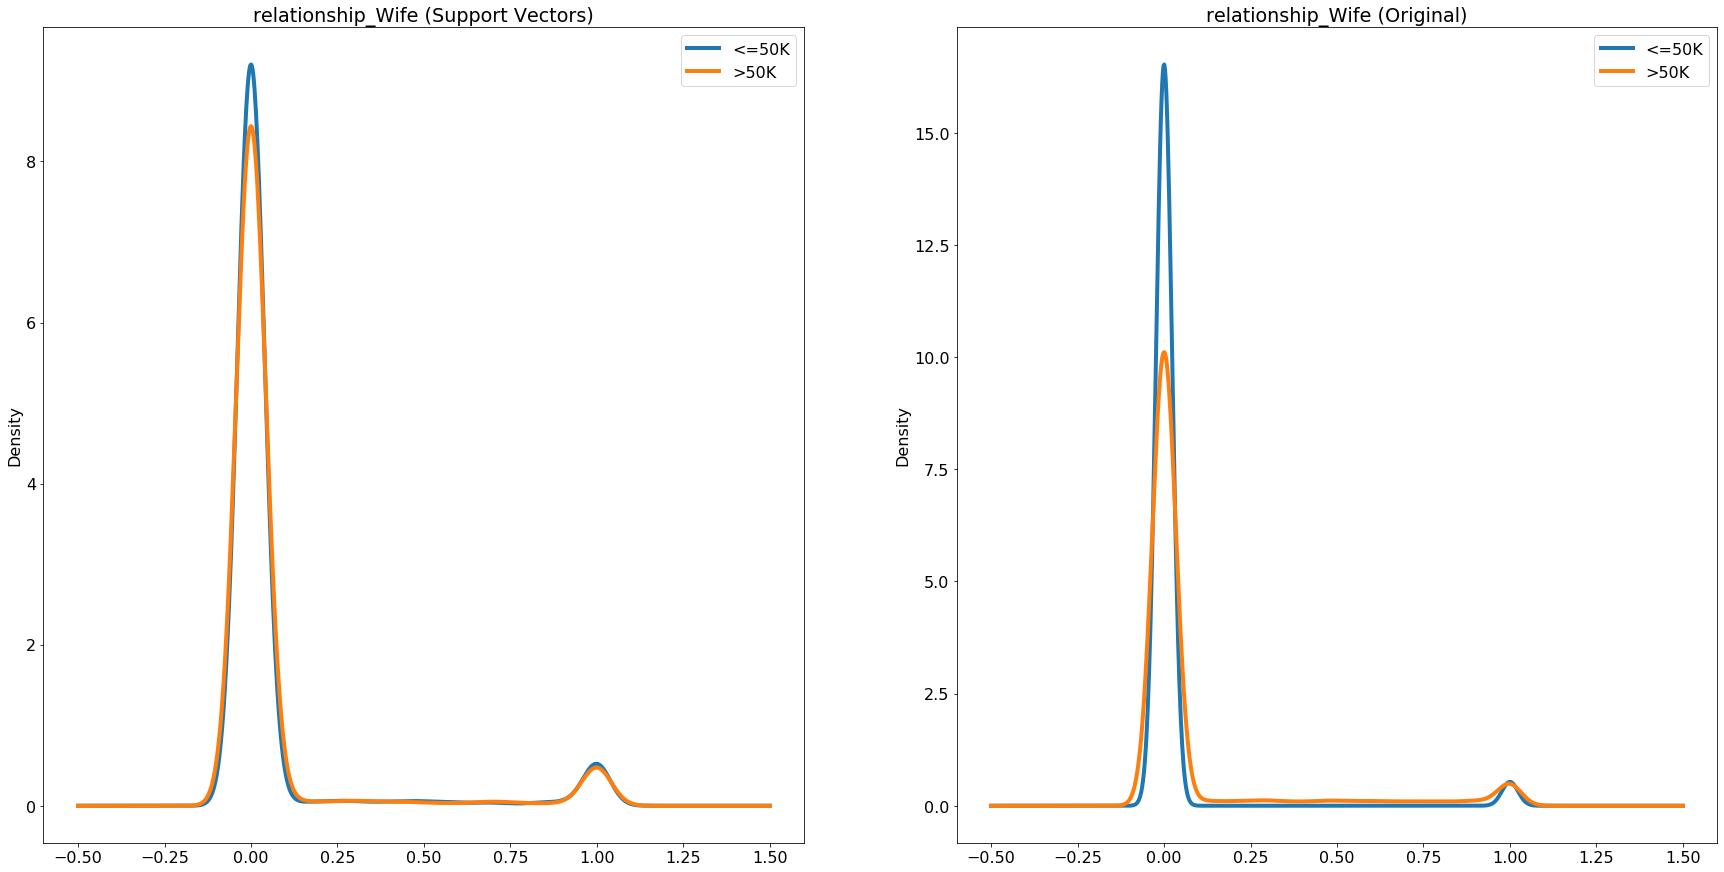

<Figure size 720x288 with 0 Axes>

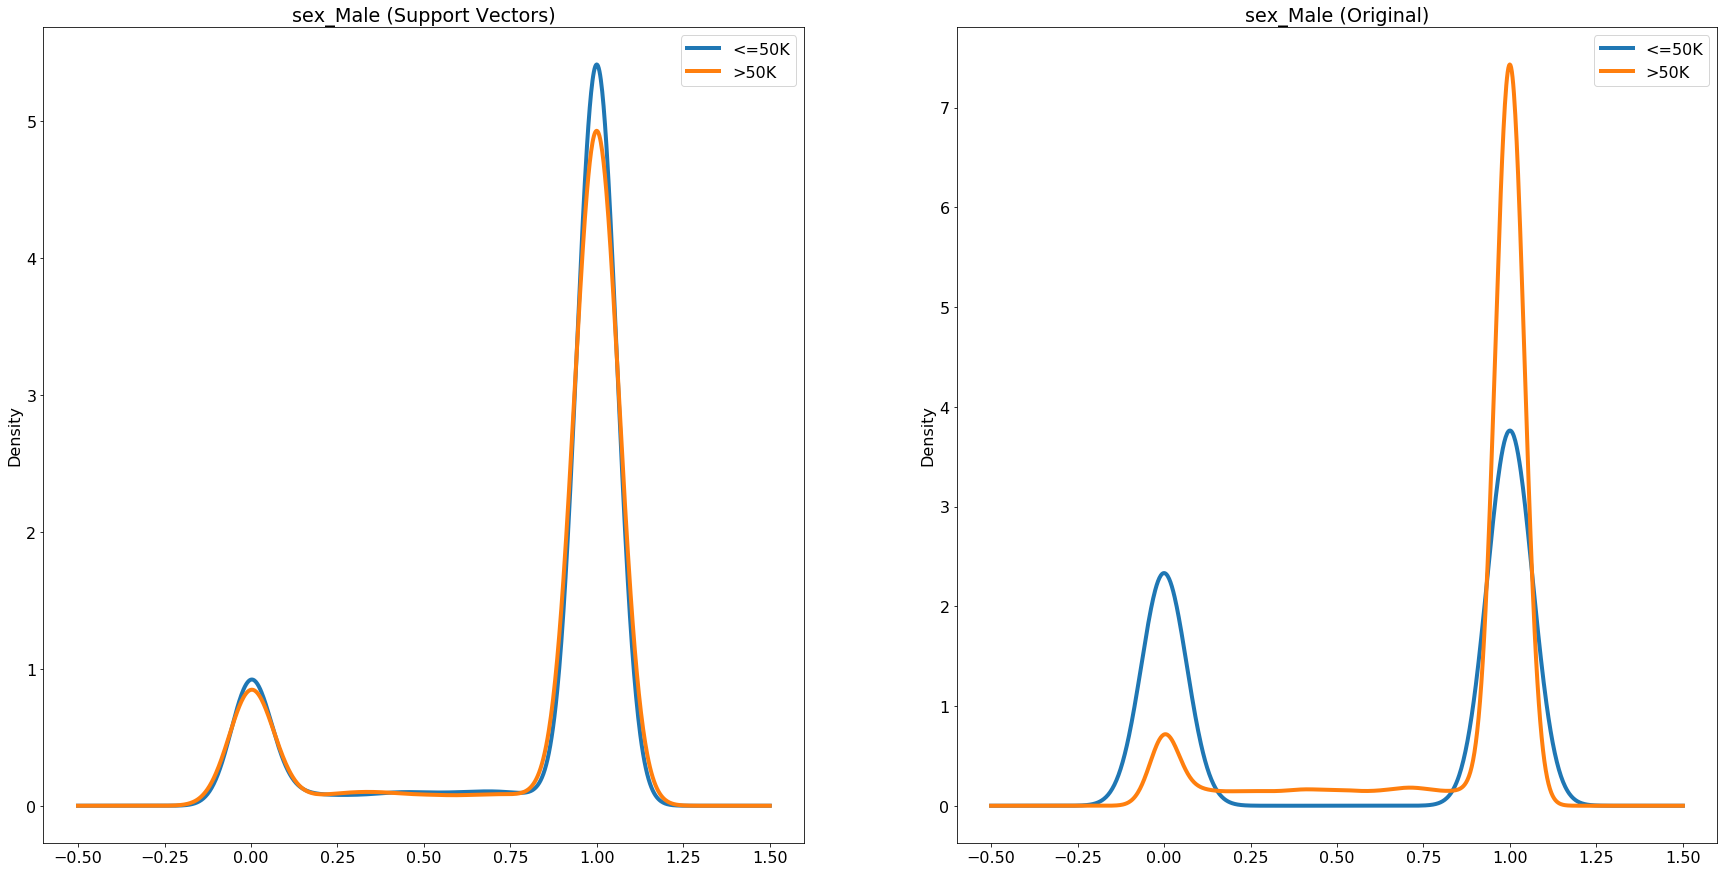

<Figure size 720x288 with 0 Axes>

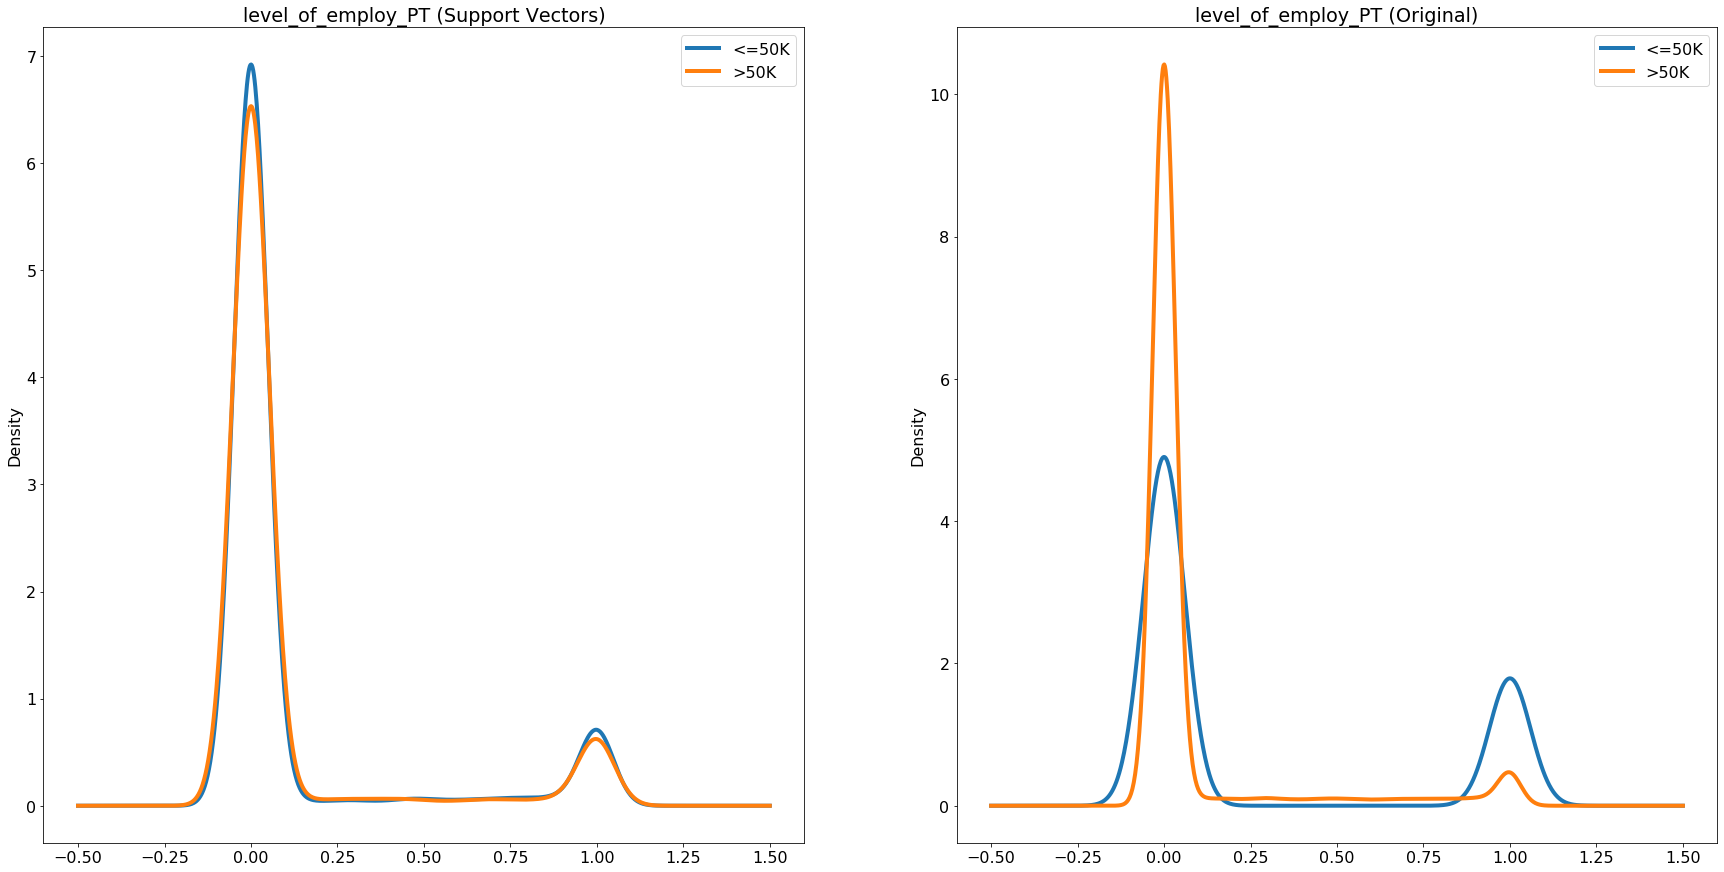

In [45]:
df_grouped_support = df_support.groupby(['income_outcome'])
df_grouped = smote_df_.groupby(['income_outcome'])

# plot KDE of Different variables
vars_to_plot = ['education_num_yr', 'cap_gain', 'age', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'sex_Male', 'level_of_employ_PT']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    plt.figure(figsize=(30,15))
    plt.rcParams.update({'font.size': 16,'lines.linewidth':4})
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['<=50K','>50K'])
    plt.title(v+' (Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['<=50K','>50K'])
    plt.title(v+' (Original)')

# 2) Model Advantages


When comparing our models for the task of predicting whether an individual makes more or less than $50,000, or main metric of success is accuracy. 

However, in addition to accuracy, we will want to keep an eye on the AUC score to ensure our accuracy is robust by using the AUC score to view the probability that the model ranks an instance of >=$50,000 higher than an instance of <$50,000. 

The runtime of the models are also taken into account, but because this classifier will not need to be real-time, we can put less weight on this metric unless the time to run the model becomes prohibitively long (e.g. > one minute). 


Before we discuss any further, let's take a look at the comparison grids

In [46]:
#logistic Regression Summary Table
lr_summary

Model   Accuracy  AUC Score  Train Time
0          LR Full  84.605154  76.572921    1.614583
1       LR Reduced  83.402605  73.823963    0.234375
2         LR SMOTE  83.230020  83.230020    2.218750
3  LR Rduced SMOTE  76.333850  76.333850    0.098958

In [47]:
#SVM Summary Table
SVM_scores = {'Model' : ['SVC-rbf', 'SGDClassifier', 'SVC-Linear'], 'Accuracy' : [mean_accuracy_SVC_rbf_GA, accuracy_sdg_mean, accuracy_SVC_linear], 'AUC Score' : [mean_auc_SVC_rbf_GA, auc_sdg_mean, auc_SVC_linear],'Train Time' : [mean_runtime_SVC_rbf_GA, runtime_sdg_mean, runtime_SVC_linear]}

SVM_summary = pd.DataFrame(data=SVM_scores)
SVM_summary

Model              Accuracy             AUC Score   Train Time
0        SVC-rbf               87.5766               87.5766      87.7917
1  SGDClassifier                82.861                82.861     0.302083
2     SVC-Linear  [0.8326322780606598]  [0.8326322780606596]  [192.21875]

##### Model Summary
As we can see form the results, the best performing logistic regression model is the SMOTE model, with a mean accuracy of 83.51%, a mean AUC score of 83.51%, and a mean train time of 1.85 seconds.  While the accuracy of the SMOTE model is about one percent less (83.51 vs 84.61) than the full model, the AUC score is increased from 76.57% to 83.94% with a similar runtime  (1.84 seconds [SMOTE] vs 1.26 seconds [full]).  The runtime for the reduced and reduced SMOTE models is about one tenth of the time, but the increase in both accuracy and AUC scores warrant selecting the SMOTE model as the preferable logistic regression model. It should be noted that the LR SMOTE model is upsampled, making it susceptible to overfitting. 

Comparing the Support Vector Machines (SVM) models, runtime becomes more important as the number of attributes drastically increases the calculation time.  Using SVC with an rbf kernel, we obtain better accuracy and AUC than all of the logistic regression models, but the runtime is between 99 and 100 seconds.  While our classifier need not be real-time, waiting a minute and a half for results is inefficient for a four percent increase in accuracy and AUC.  

Using SGD Classifier combined with a grid search to tune the parameters and SMOTE up sampling, we observe similar metrics to our SMOTE logistic regression model. The mean accuracy is 83.49%, AUC score of 83.49%, and a mean runtime of 0.34 seconds.  

Using a linear SVC and a subsampled population, we were able to achieve an accuracy of 83.75%, an AUC score of 83.75%, and a train time of 167.73 seconds.  The train time for this model was significantly longer than the rbf kernel, and would be prohibitively long if we were to use the entire data set.  For the reasons stated, we only ran one iteration in order to obtain the support vectors for analysis.  


##### Accuracy
In terms of overall accuracy, the SVC-rbf model performed the best with a mean accuracy of 87.64%, over three percent higher than the LR Full model which came in second with 84.61%.  The SVC-rbf model also had the highest AUC score with 87.64% which bested the LR SMOTE model (83.37) by over four percent.  With the Train Time at 73.16 seconds, it is the second slowest model, but wins in the case where accuracy is key and time is not a factor.  

##### Train Time
If train time became a significant factor in the business use case of the model, the SDGClassifier model had the fastes Train Time while still scoring 83.23% for both accuracy and AUC Score.  While the SDGClassifier is only the fifth best performing in terms of accuracy, it ranks in foruth when it comes to AUC Score.  Therefore, when time is of the essence, the SdGClassifier can perform quickly while maintianing high accruacy and AUC scores.  

# 3) Interpret Feature Importance

In [48]:
#### WEIGHT GRAPH FOR LR Smote MODEL
error_y=dict(
            type='data',
            array=np.std(weights_smote,axis=0),
            visible=True
        )

graph1 = {'x': ml_df.columns,
          'y': np.mean(weights_smote,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars (LR SMOTE Model)', 'height': 1000, 'width': 1400, 'font': {'size':14}}
plotly.offline.iplot(fig)

With the SMOTE model being the best performing logistic regression model, we will look into the weights derived from that model.  However, because there are 71 attributes, we will examine in detail the five attributes with the highest absolute weight value.

-cap_gain 

cap_gain has a weight of 3.00.  Because cap_gain is a continuous attribute, we can interpret the weight as a one unit increase of cap_gain will increase the odds of a given individual making over 50,000 by a factor of 20.  This attribute is crucial to our model as no other attribute weights even approached the value of one.  Applying common sense, it would follow that those with greater capital gains have a greater chance of making over 50,000 per year, as you need money to invest in order to have any capital gains.  Those who make less than 50,000 likely allocate their income to essential costs such as housing, food, clothing, and transportation.

-marital_status_Married-civ-spouse 

marital_status_Married-civ-spousehas a weight of 0.55. marital_status is a categorical attribute, therefore we can interpret the weight as a change from the reference value of marital_status_Divorced to marital_status_Married-civ-spouse increases the odds of the individual making over $50,000 per year by 73%, or a multiplicative factor of 1.73.

-age 

age has a weight of 0.52.  Again we have a continuous variable, so we can interpret this as a one unit increase in age increases the odds of making over $50,000 by a multiplicative factor of 1.68 (a 68% greater chance).  This conclusion also passes the common sense test as on average, wages increase with age and experience.    

-marital_stat_Unmarried 

marital_status_Unmarried has a weight of -0.49.  Again we have marital_status, which is a categorical attribute, therefore we can interpret the weight as a change from the reference value of marital_stat_Married to marital_status_Unmarried decreases the odds of the individual making over $50,000 per year by 39%, or a multiplicative factor of 0.61.  

-sex_Male 

sex_Male has a weight of 0.39.  here we have a binary variable, so we can interpret the weight of sex_Male as changing from a 0 (female) to a 1 (male) increases the odds of the individual making over $50,000 by 48%, or a multiplicative factor of 1.48.  


# 4) Interpret Support Vectors

<Figure size 720x288 with 0 Axes>

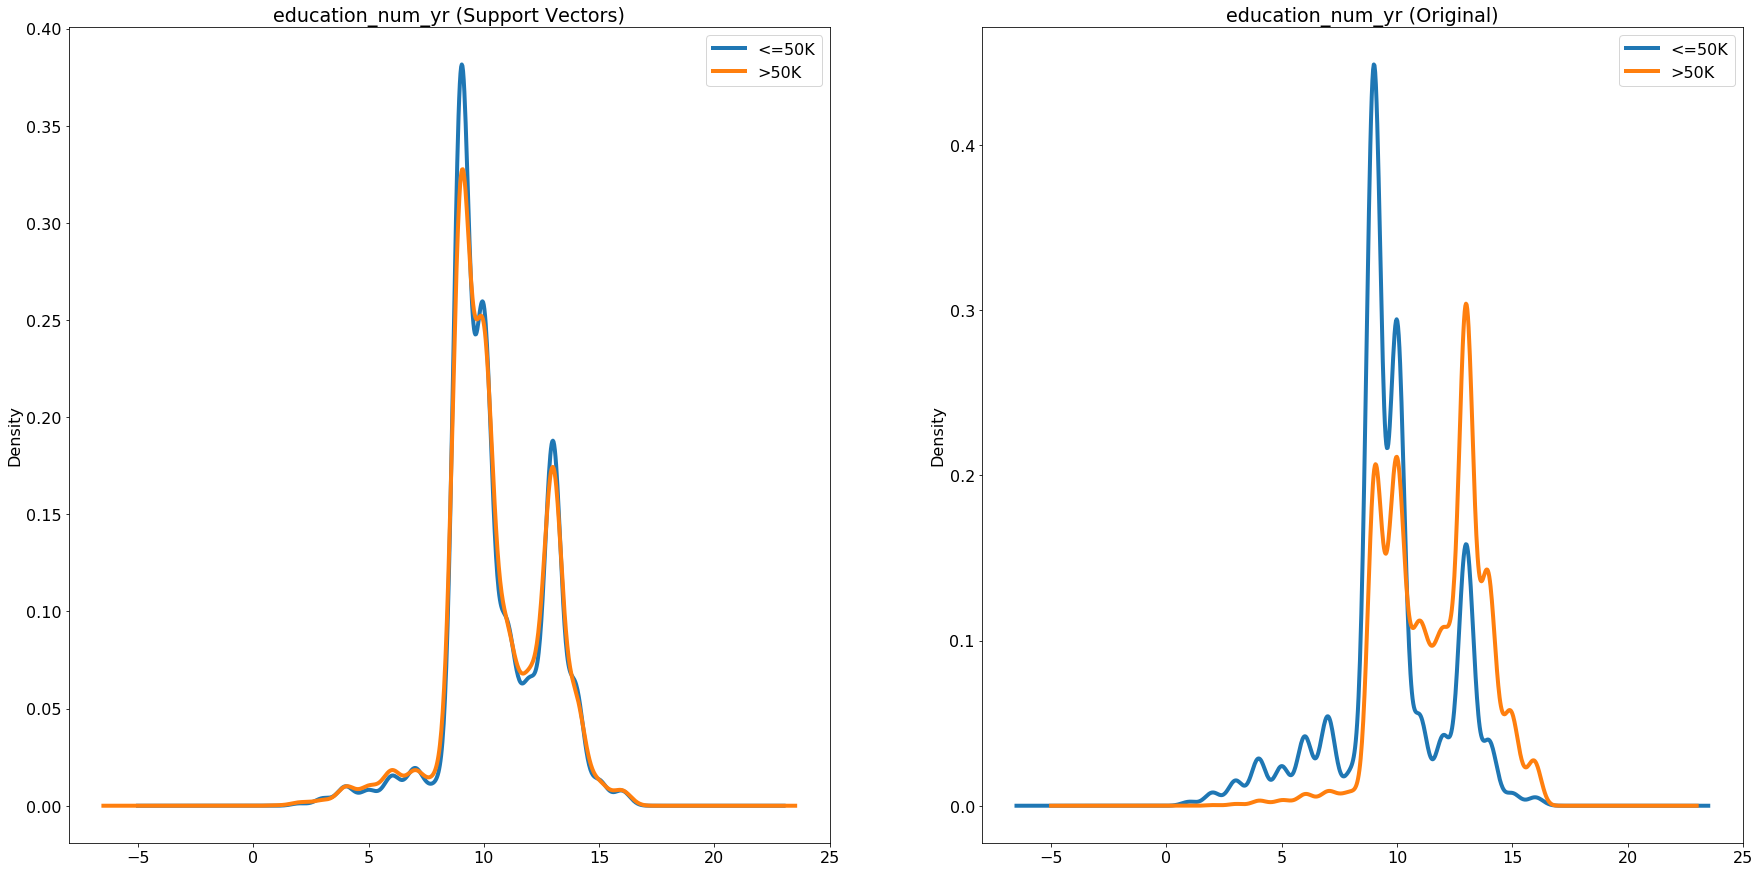

<Figure size 720x288 with 0 Axes>

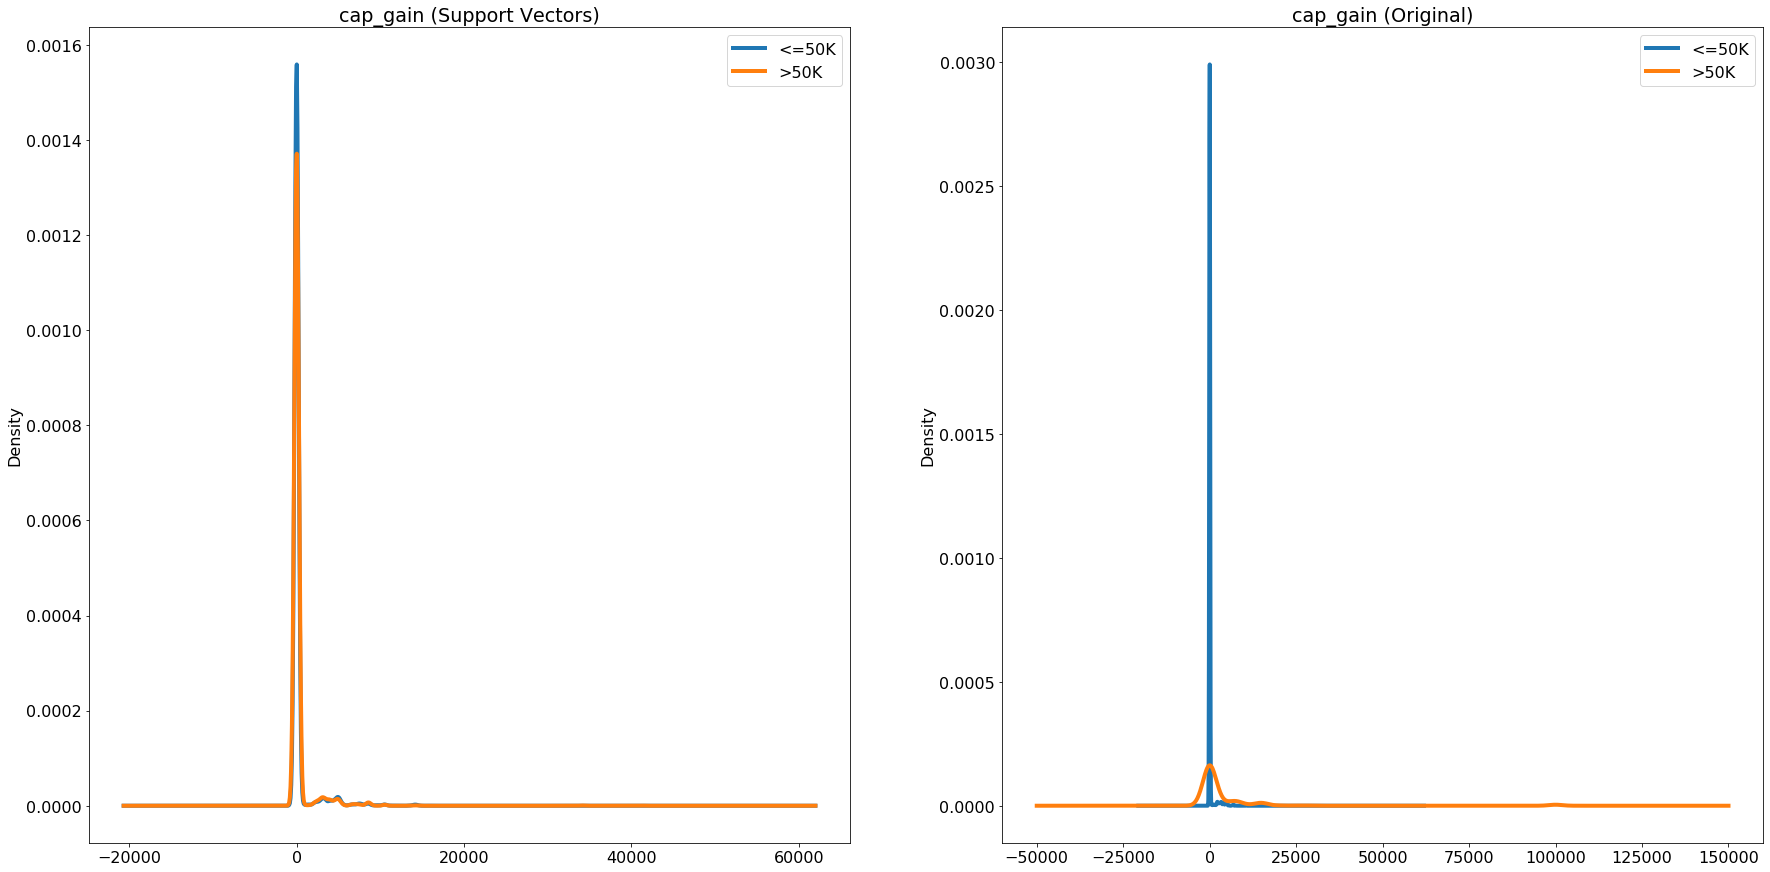

<Figure size 720x288 with 0 Axes>

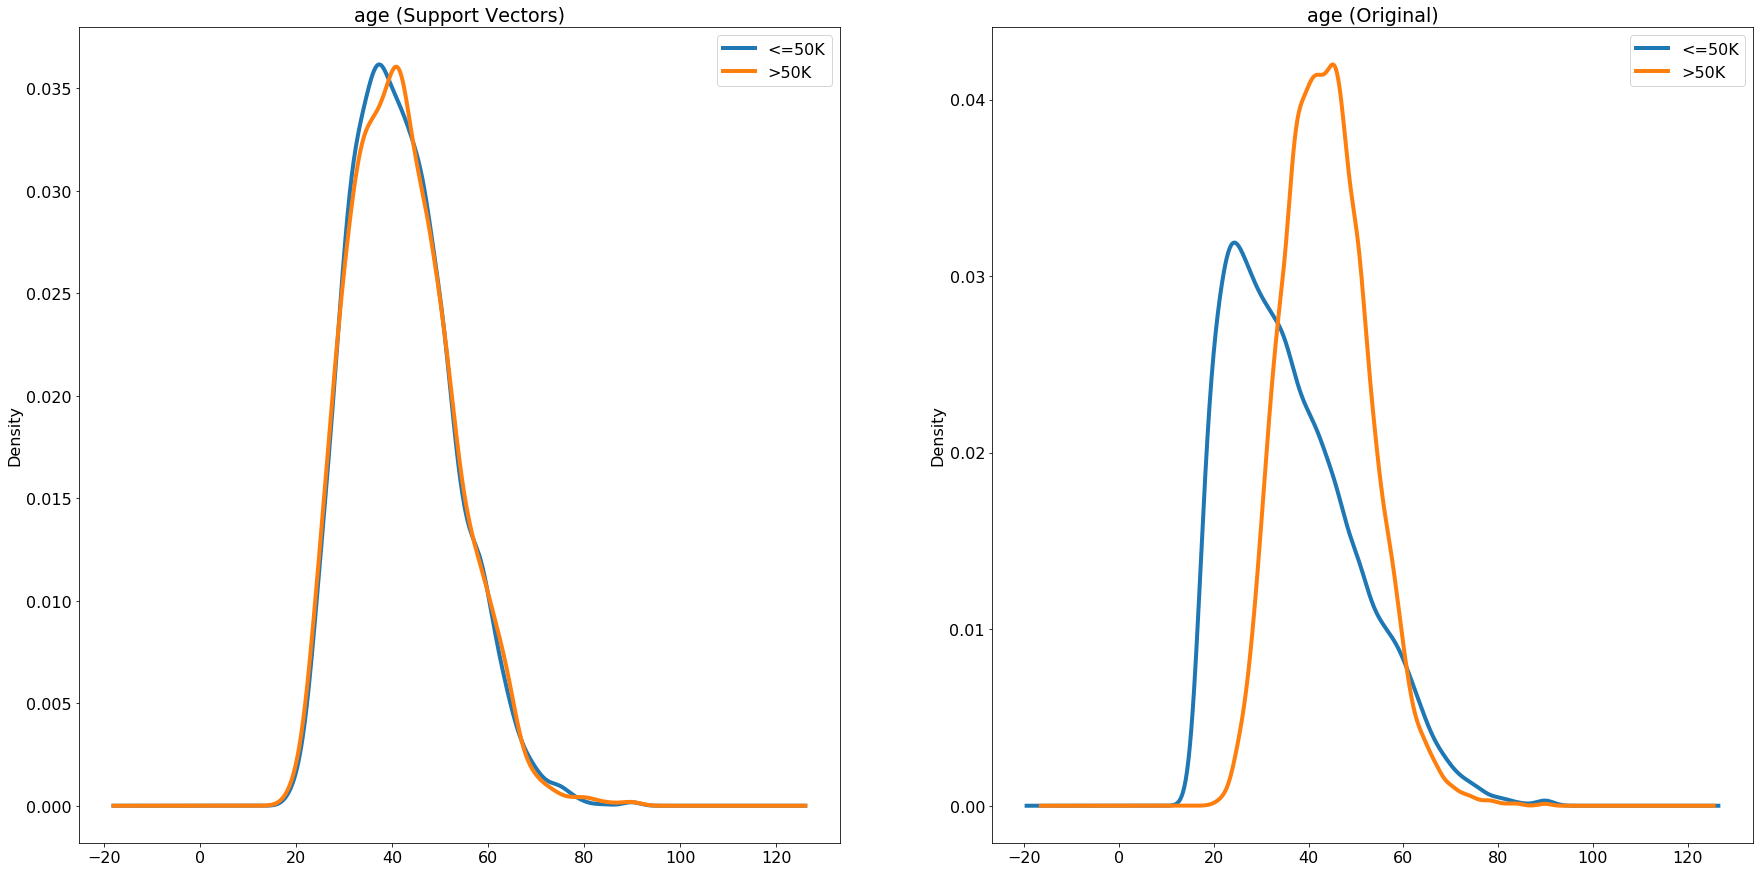

<Figure size 720x288 with 0 Axes>

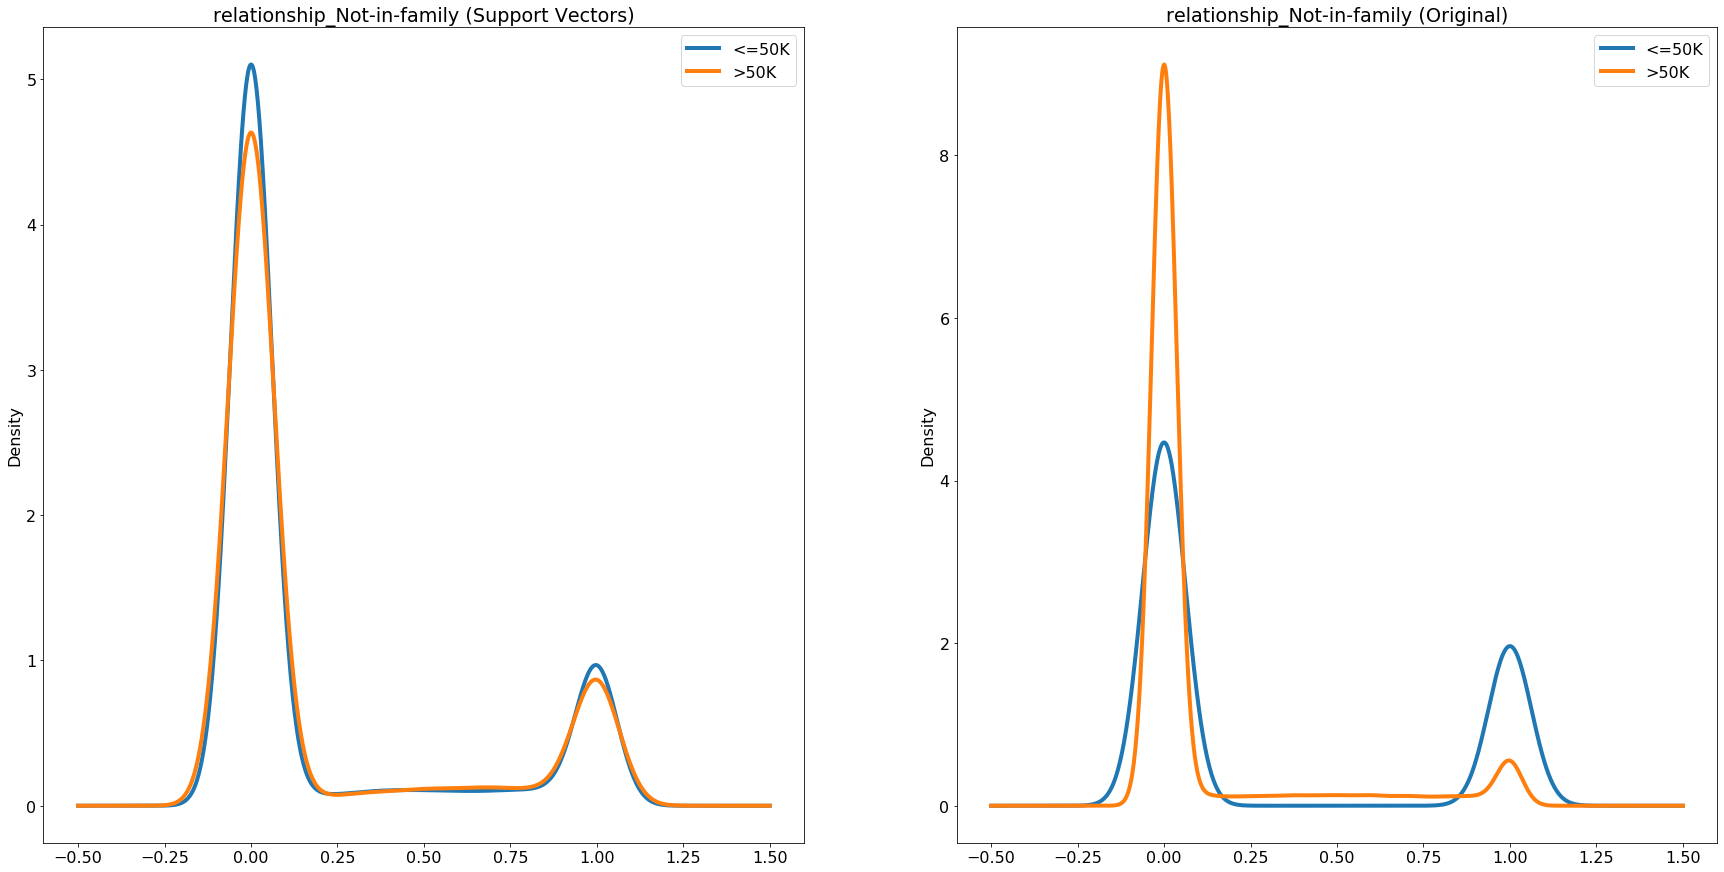

<Figure size 720x288 with 0 Axes>

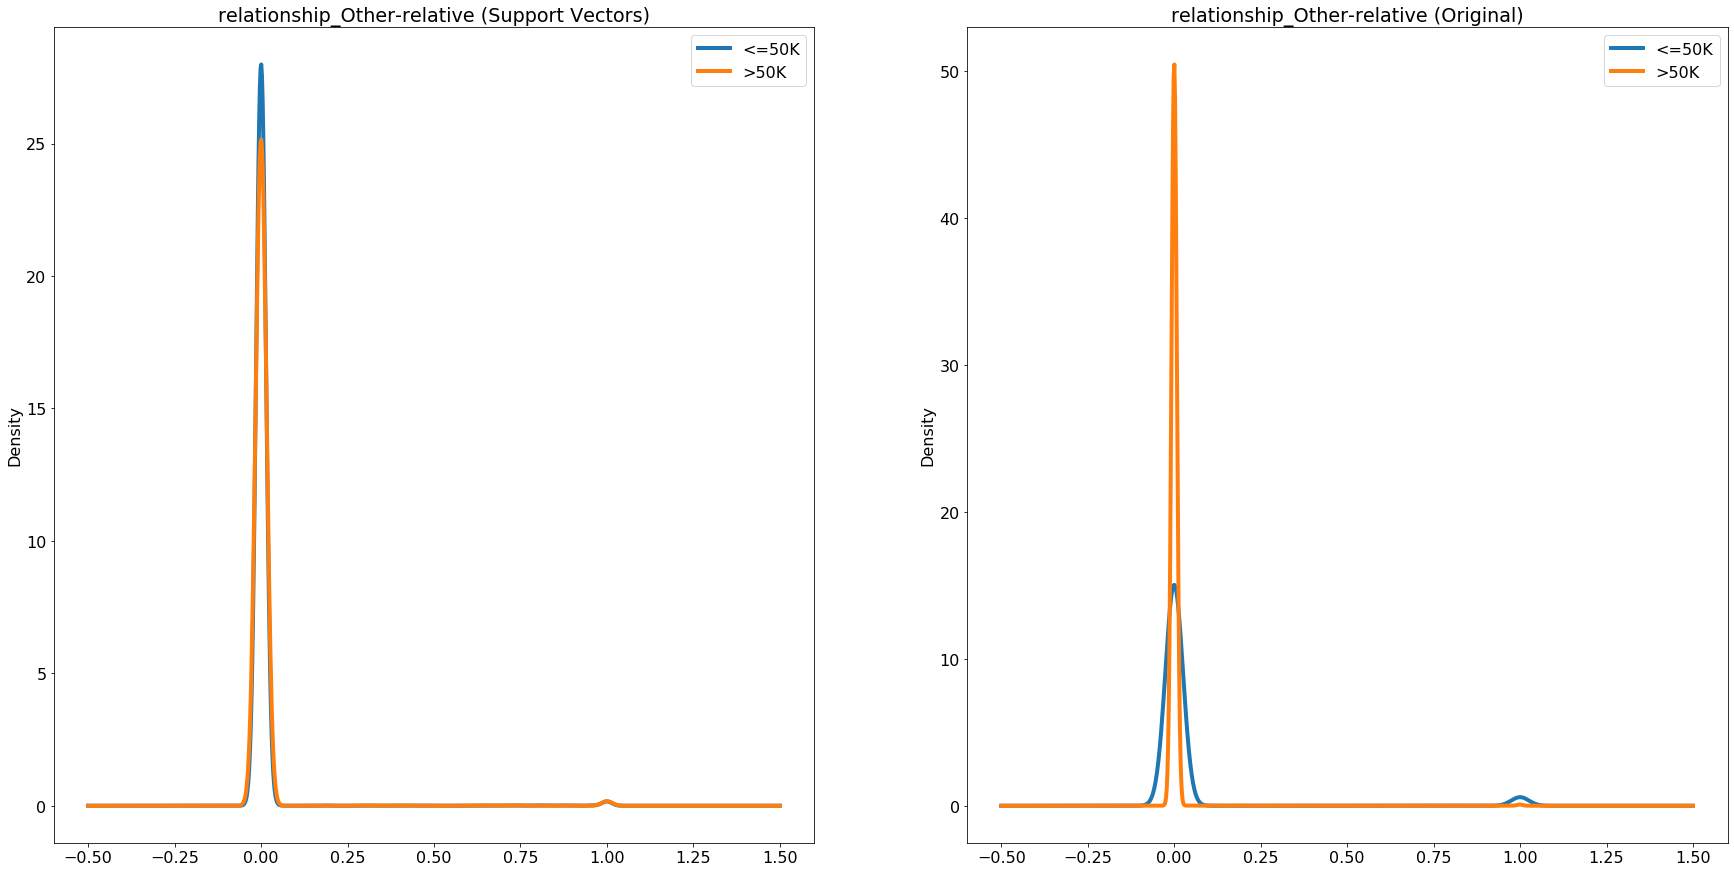

<Figure size 720x288 with 0 Axes>

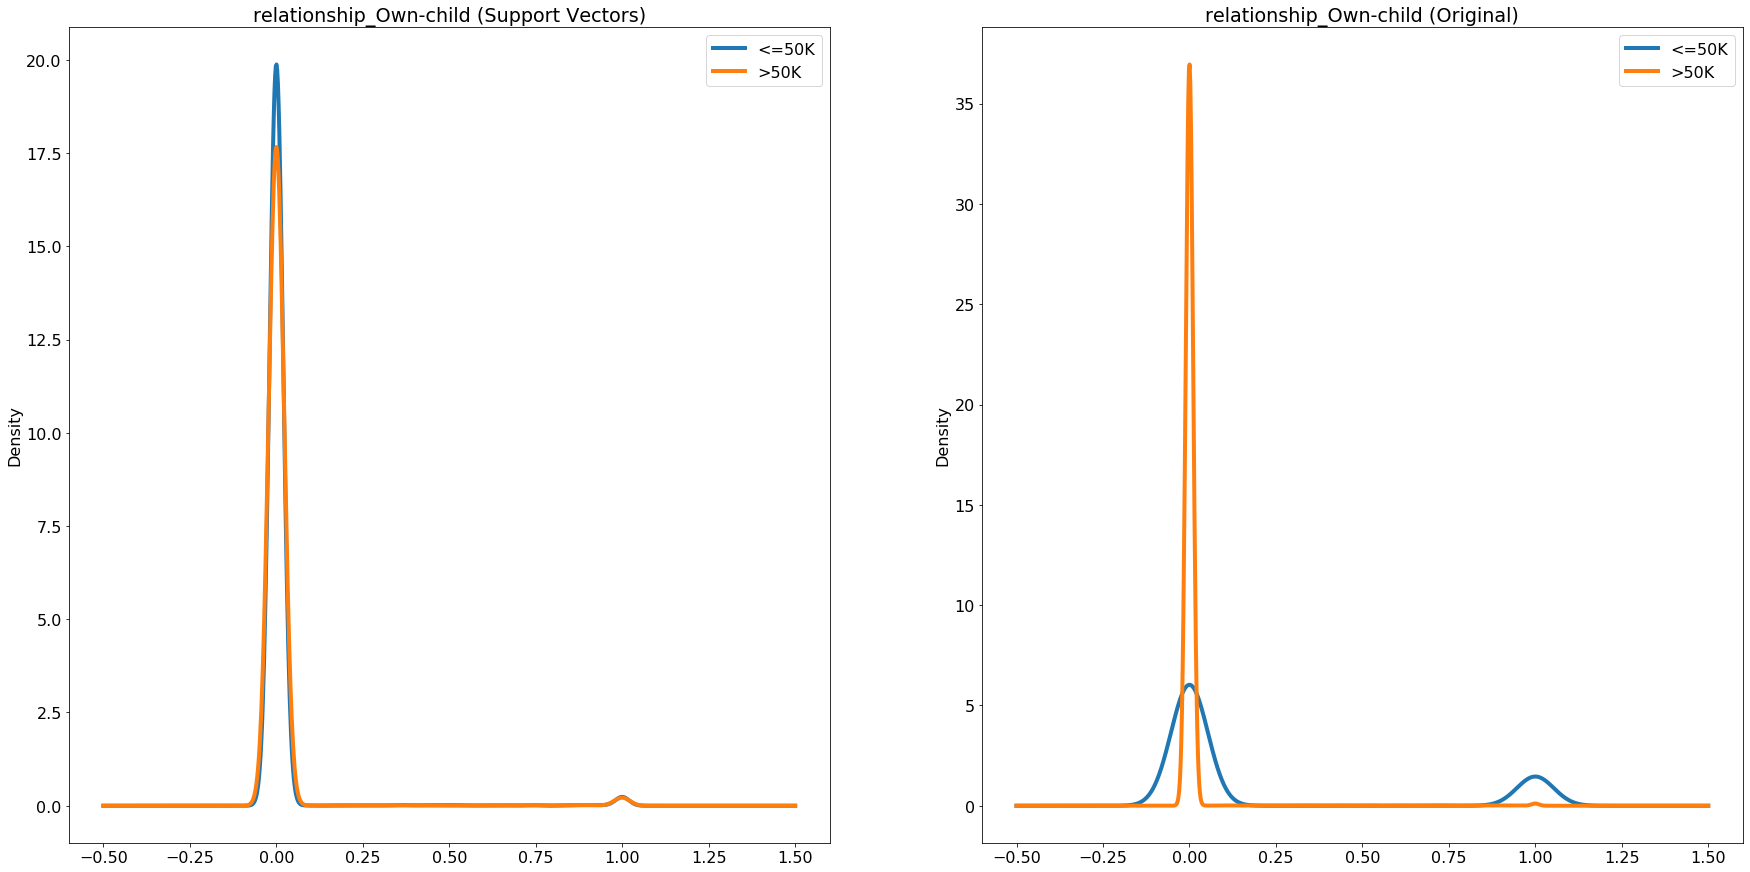

<Figure size 720x288 with 0 Axes>

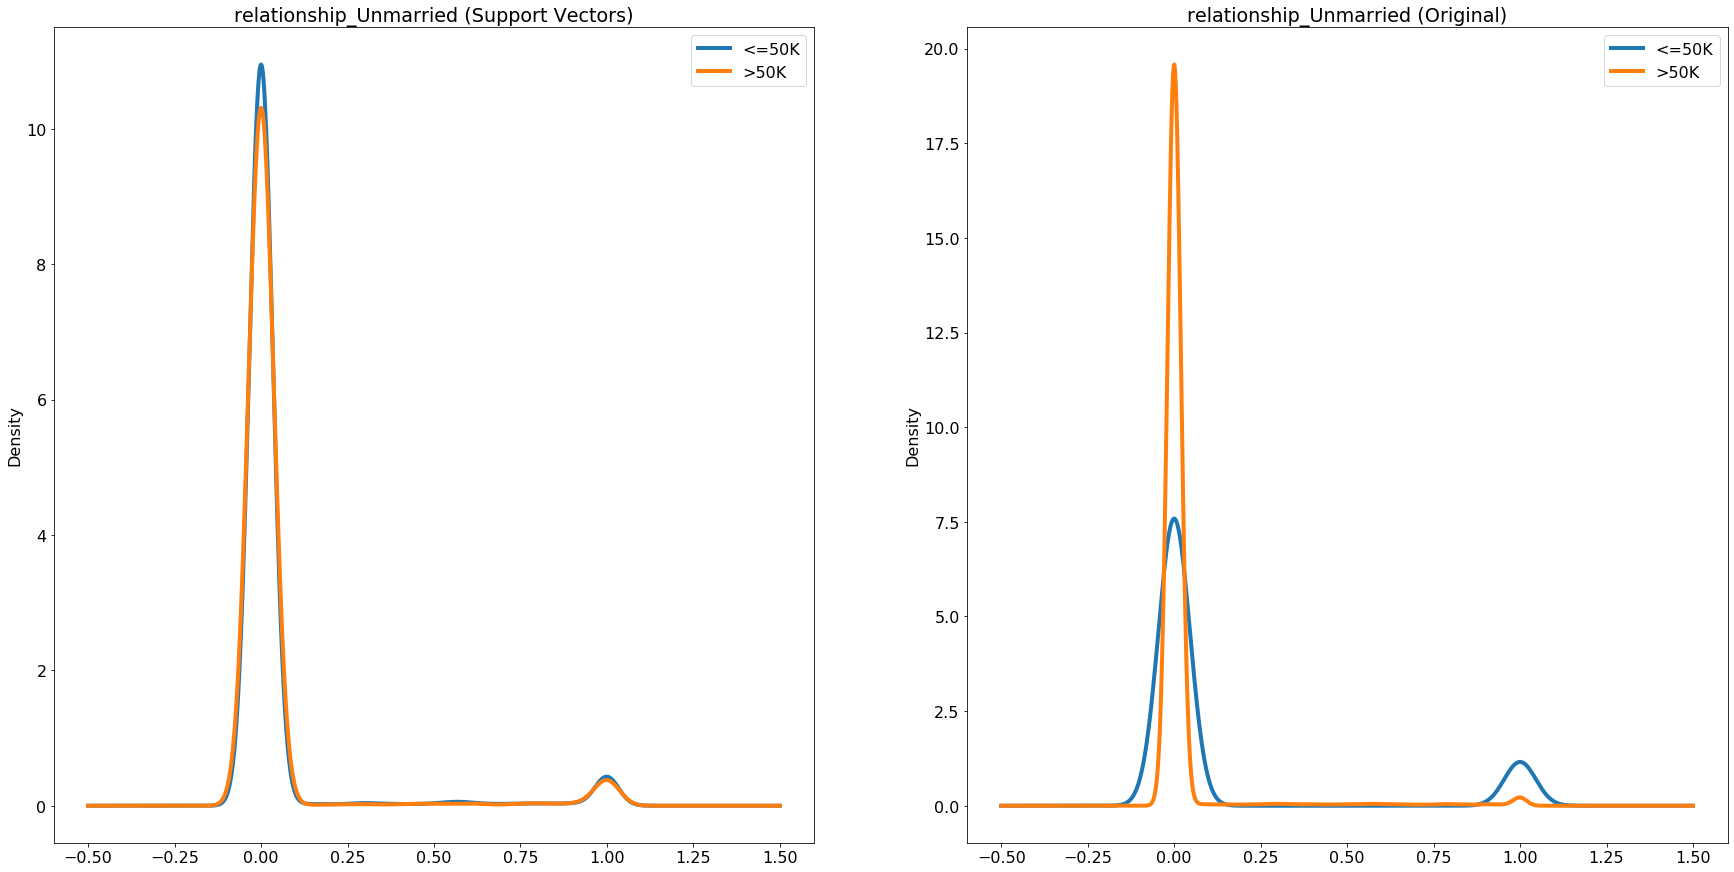

<Figure size 720x288 with 0 Axes>

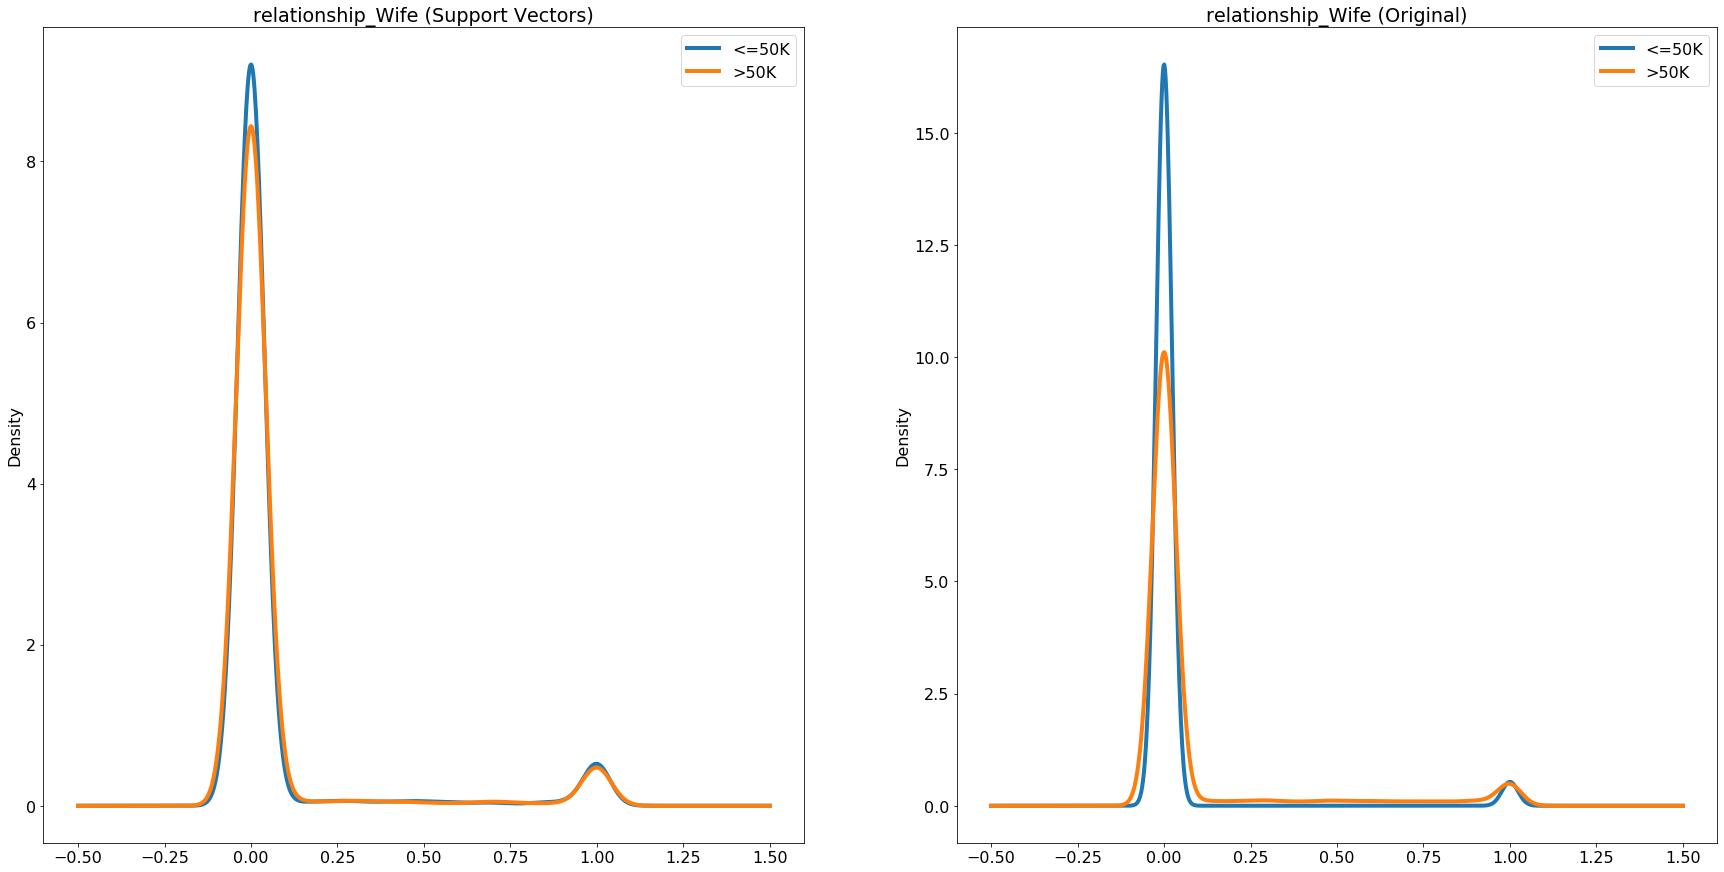

<Figure size 720x288 with 0 Axes>

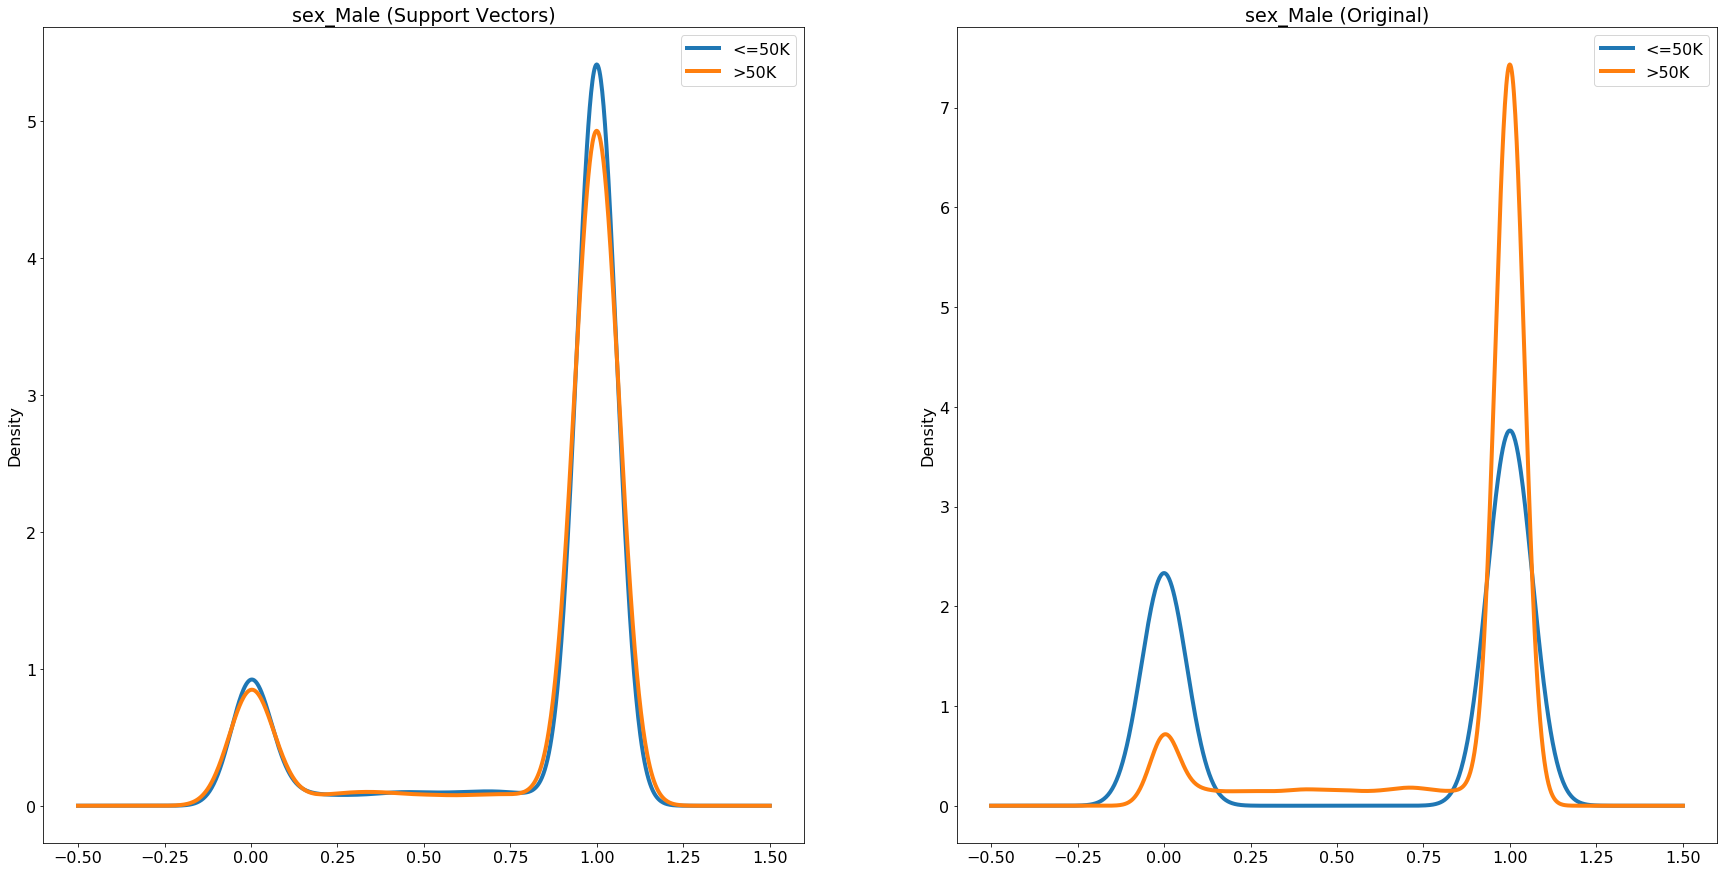

<Figure size 720x288 with 0 Axes>

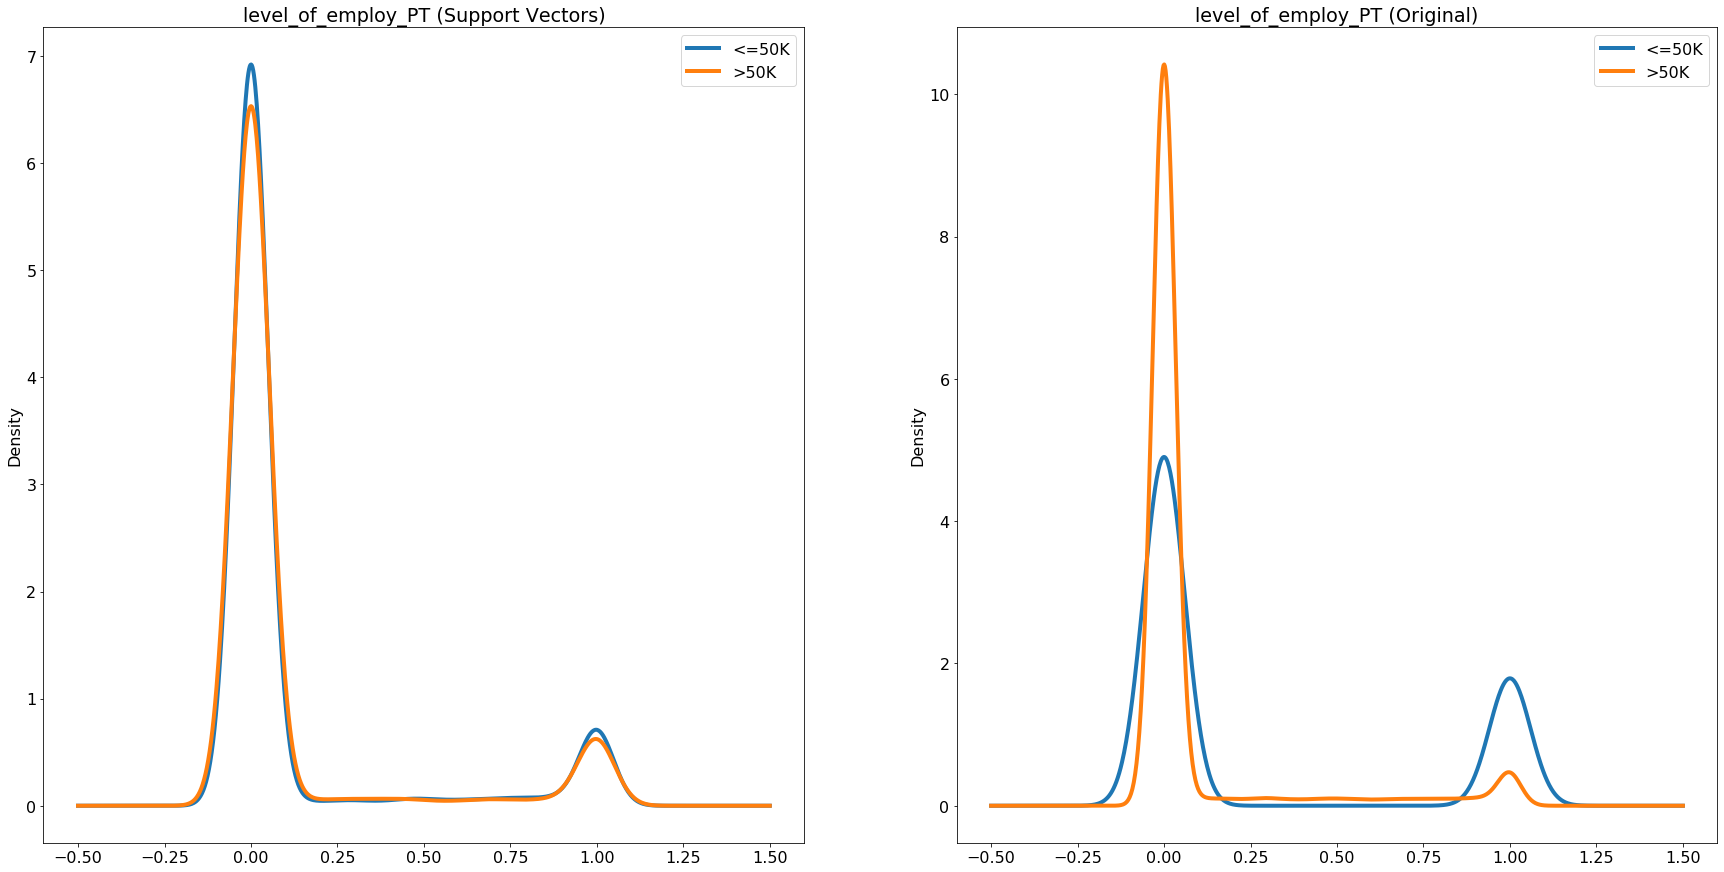

In [49]:
#Support vectors from the linear SVC model


df_tested_on = smote_df_.iloc[train_indices].copy() 
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['income_outcome'] = y_upsam_smote_[svm_clf.support_] 
df_grouped_support = df_support.groupby(['income_outcome'])
df_grouped = smote_df_.groupby(['income_outcome'])

# plot KDE of Different variables
vars_to_plot = ['education_num_yr', 'cap_gain', 'age', 'relationship_Not-in-family', 'relationship_Other-relative', 'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife', 'sex_Male', 'level_of_employ_PT']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    plt.figure(figsize=(30,15))
    plt.rcParams.update({'font.size': 16,'lines.linewidth':4})
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['<=50K','>50K'])
    plt.title(v+' (Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['<=50K','>50K'])
    plt.title(v+' (Original)')

Using linear SVC on a subsampled population, we can extract and examine the statistics for the chosen support vectors (left) compared to the density of the original data (right).  The total nuber of support vectors is 71, therefore we will look at the comparisons of the ten most important: education_num_yr, cap_gain, age, relationship_Not-in-family, relationship_Other-relative, relationship_Own-child, relationship_Unmarried, relationship_Wife, sex_Male, level_of_employ_PT.

Across all ten examples displayed above, we see significant decreases of the distance between the over 50,000 and the less than or equal to 50,000 distributions as the support vectors are instances close to (or on) the decision boundary.  

One outstanding example is relationship_Not-in-family.  We can see that the original data bimodal distribution has less than 50,000 with a pek around 7 with over 50,000 coming in just over 4.  In the support vecotr graph we can see that that gap is nearly closed with less than 50,000 at 5 and over 50,000 at approximately 4.5.

relationship_Other-relative is another excellent example. The original data distribution shows over 50,000 nearing 50.  Wile this spike is extremely thin, the speak of the under 50,000 only reaches 15.  Changing over to our support vector density plot on the left, we can see that both peaks are near 25.  Similar relationships can be observed with the relationship_own-child and relationship_Unmarried density plot comparisons as well. 


# Rubric Sections

https://www.datasciencecentral.com/profiles/blogs/crisp-dm-a-standard-methodology-to-ensure-a-good-outcome

Create Models: 

50 PTS 

Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

Model Advantages: 

10 PTS 

Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

Interpret Feature Importance: 

30 PTS 

Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

Interpret Support Vectors: 

10 PTS 

Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.